<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Subscription Prediction with Delat Lake, PySpark, and MLlib</h1>

<h1><i><font color=blue>Please note:</i></h1>
<i><font size='4'>A few changes to the original class repo notebook were made:</font></i>
<ul>
<li>used the complete <code>bank-full.csv</code> data file (45,212 records) instead of <code>bank.csv</code> (4,522 records)
<li>converted the pandas-on-spark <code>sdf</code> dataframe to a pandas dataframe, <code>sdf_pd</code>, in order to do basic EDA using <code>SweetViz</code>
<li>after looking at data via <code>SweetViz</code>, did a little more data cleaning
<li>converted cleaned pandas <code>sdf_pd</code> dataframe back to (py)spark <code>sdf_ps</code> dataframe
<li>checked for data imbalance with respect to the target binary label classes in final dataset (ratio of negatives to positives <code>= 7.6:1</code> → made no further changes)
</font></ul>

# _Preliminaries:_
#### _Aim:_ 
Trying to use a dataset of various features to predict whether or not a customer will subscribe to a term deposit at a Portuguese bank.

#### _A __term deposit__ is:_
*   a fixed-term investment at a bank that pays higher interest rates than traditional savings accounts
*   requires customer to deposit money for a specified length of time, during which the funds are 'locked-up' (i.e., may not be withdrawn; or in some cases, may be withdrawn early at the expense of a penalty fee)

#### _Key cells:_
*   [Set up Py project `ml-bank` by installing Delta Lake, and then configuring SparkSession with utility in Delta Lake](#019994671)
*   [Using Pandas on Spark, `pyspark.pandas`](#921020947)
*   [Feature transformation: use `StringIndexer` to index categorical features → convert to one-hot encoded variables → use `VectorAssembler` to concatenate all feature columns into one vector column; also, use `StringIndexer` to encode labels to label indices](#81414208434)
*   [Create pipeline](#7419952)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Spark Environment

Make sure that you open this notebook in your Spark environment!

In [2]:
!pip install -U -q pyspark delta-spark # If you use Colab uncomment this line

     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 36.0 MB/s 


In [3]:
!pyspark --version
!which pyspark

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 11.0.16
Branch HEAD
Compiled by user ubuntu on 2022-06-09T19:58:58Z
Revision f74867bddfbcdd4d08076db36851e88b15e66556
Url https://github.com/apache/spark
Type --help for more information.
/usr/local/bin/pyspark


## Learning Objectives

At the end of this session, you will be able to 

- Load, save, partition data with Delta Lake tables
- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [4]:
%%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2022-09-21 17:55:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8%  371K 1s
    50K .......... .......... .......... .......... .......... 17%  747K 1s
   100K .......... .......... .......... .......... .......... 26% 54.5M 1s
   150K .......... .......... .......... .......... .......... 35%  763K 0s
   200K .......... .......... .......... .......... .......... 44% 37.1M 0s
   250K .......... .......... .......... .......... .......... 53% 41.7M 0s
   300K .......... .......... .......... .......... .......... 61% 79.2M 0s
   350K .......... .......... .......... .......... .......... 70%  784K 0s
   400K ........

In [5]:
ls

bank.zip  drive/  sample_data/


1. Unzip the file and use `ls` to see the files.

In [6]:
%%sh
unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [7]:
ls -lh

total 5.5M
-rw-r--r-- 1 root root 451K Feb 14  2012 bank.csv
-rw-r--r-- 1 root root 4.4M Feb 14  2012 bank-full.csv
-rw-r--r-- 1 root root 3.8K Feb 14  2012 bank-names.txt
-rw-r--r-- 1 root root 566K Feb 14  2012 bank.zip
drwx------ 5 root root 4.0K Sep 21 17:53 drive/
drwxr-xr-x 1 root root 4.0K Sep 14 13:44 sample_data/


In [8]:
pwd

'/content'

In [9]:
%%sh
wc -l bank.csv    # show number of data rows
wc -l bank-full.csv    # take a look at # row in bank-full.csv

4522 bank.csv
45212 bank-full.csv


## _Let's work with the bank-full.csv instead!_
(has 10x more records)

In [10]:
%%sh
head bank-full.csv

"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
58;"management";"married";"tertiary";"no";2143;"yes";"no";"unknown";5;"may";261;1;-1;0;"unknown";"no"
44;"technician";"single";"secondary";"no";29;"yes";"no";"unknown";5;"may";151;1;-1;0;"unknown";"no"
33;"entrepreneur";"married";"secondary";"no";2;"yes";"yes";"unknown";5;"may";76;1;-1;0;"unknown";"no"
47;"blue-collar";"married";"unknown";"no";1506;"yes";"no";"unknown";5;"may";92;1;-1;0;"unknown";"no"
33;"unknown";"single";"unknown";"no";1;"no";"no";"unknown";5;"may";198;1;-1;0;"unknown";"no"
35;"management";"married";"tertiary";"no";231;"yes";"no";"unknown";5;"may";139;1;-1;0;"unknown";"no"
28;"management";"single";"tertiary";"no";447;"yes";"yes";"unknown";5;"may";217;1;-1;0;"unknown";"no"
42;"entrepreneur";"divorced";"tertiary";"yes";2;"yes";"no";"unknown";5;"may";380;1;-1;0;"unknown";"no"
58;"retired";"married";"primary";"no";121;"yes

1. Create a Delta table for `bank.csv` (Why Delta Lake? Here's a read [here](https://medium.com/@databeans-blogs/delta-lake-the-data-engineers-missing-piece-part-1-ebab66a3f8c0?source) from a data engineer's perspective)

*   We first set up a Python project `ml-bank`, configure the SparkSession with the `configure_spark_with_delta_pip()` utility function in Delta Lake
*   See specific Delta Lake documentation here, which provides code snippets




<a name='019994671'></a>
### _NB:_ Set up Py project `ml-bank` and create SparkSession with utility in Delta Lake _(from Delta Lake Documentation)_
To set up a Python project, you can install Delta Lake using `pip install delta-spark==2.1.0` and then configure the SparkSession with the `configure_spark_with_delta_pip()` utility function in Delta Lake [see here](https://docs.delta.io/latest/quick-start.html)

In [11]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("ml-bank") \
  .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
  .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

   We define output formats and paths, you need to complete code to load the data from its source (since the delimiter of the file is semicolon, use [`spark.read.csv`](https://spark.apache.org/docs/latest/sql-data-sources-csv.html) that provides more flexibility) and write the data to its target (hint: [Create a table](https://docs.databricks.com/delta/quick-start.html#create-a-table)).

In [12]:
# Define the input and output formats and paths and the table name.
write_format = 'delta'
load_path = 'bank-full.csv'
save_path = '/tmp/delta/bank-40k'
table_name = 'default.bank40k'

# Load the data from its source.
df = spark.read.format('csv') \
    .option('delimiter', ';') \
    .option('inferSchema', 'true') \
    .option('header', 'true') \
    .load(load_path)

display(df)

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, y: string]

In [13]:
# check dataframe type:
type(df)

pyspark.sql.dataframe.DataFrame

In [14]:
# Write the data to its target.
df.write.format(write_format).save(save_path)

1. Verify what we just created.

In [15]:
ls -lha /tmp/delta/bank-40k/

total 380K
drwxr-xr-x 3 root root 4.0K Sep 21 17:58 ./
drwxr-xr-x 3 root root 4.0K Sep 21 17:58 ../
drwxr-xr-x 2 root root 4.0K Sep 21 17:58 _delta_log/
-rw-r--r-- 1 root root 326K Sep 21 17:58 part-00000-0d59bf7c-755c-4f43-a680-ea5aba231224-c000.snappy.parquet
-rw-r--r-- 1 root root 2.6K Sep 21 17:58 .part-00000-0d59bf7c-755c-4f43-a680-ea5aba231224-c000.snappy.parquet.crc
-rw-r--r-- 1 root root  31K Sep 21 17:58 part-00001-6b7e411c-62ff-4cab-a3ab-aecdc0bd06a9-c000.snappy.parquet
-rw-r--r-- 1 root root  256 Sep 21 17:58 .part-00001-6b7e411c-62ff-4cab-a3ab-aecdc0bd06a9-c000.snappy.parquet.crc


#### _...OK, now we have 2 parquet files (instead of one with the smaller bank.csv dataset)!_

In [16]:
ls -lha /tmp

total 496K
drwxrwxrwt  1 root root 4.0K Sep 21 17:58 ./
drwxr-xr-x  1 root root 4.0K Sep 21 16:35 ../
drwxr-xr-x 65 root root 4.0K Sep 21 17:59 blockmgr-2dba9e69-770b-44c2-81ee-b4c5645dac82/
-rw-r--r--  1 root root 1.2K Sep 21 16:35 dap_multiplexer.e638eaaf50a9.root.log.INFO.20220921-163516.42
lrwxrwxrwx  1 root root   61 Sep 21 16:35 dap_multiplexer.INFO -> dap_multiplexer.e638eaaf50a9.root.log.INFO.20220921-163516.42
srwxr-xr-x  1 root root    0 Sep 21 16:35 debugger_1jv4hpn6p4=
drwxr-xr-x  3 root root 4.0K Sep 21 17:58 delta/
-rw-r--r--  1 root root 1.7K Sep 21 17:53 directoryprefetcher_binary.e638eaaf50a9.root.log.INFO.20220921-175338.1185
lrwxrwxrwx  1 root root   74 Sep 21 17:53 directoryprefetcher_binary.INFO -> directoryprefetcher_binary.e638eaaf50a9.root.log.INFO.20220921-175338.1185
srw-------  1 root root    0 Sep 21 17:53 drivefs_ipc.0=
srw-------  1 root root    0 Sep 21 17:53 drivefs_ipc.0_shell=
drwxr-xr-x  2 root root 4.0K Sep 21 17:57 hsperfdata_root/
drwx------  2 roo

1. Partition data by `job` status. 

  To speed up queries that have predicates involving the partition columns, we should partition data. Often time, we partition by anonymized user id; here we demonstrate the idea with `job`.

In [17]:
import shutil
shutil.rmtree(save_path) # To replace data, we need to remove the existing directory

In [18]:
ls -lha /tmp/delta

total 8.0K
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 ./
drwxrwxrwt 1 root root 4.0K Sep 21 17:58 ../


In [19]:
partition_by = 'job'

# Write the data to its target.
df.write \
    .partitionBy(partition_by) \
    .format(write_format) \
    .save(save_path)

In [20]:
ls -lh /tmp/delta/bank-40k

total 52K
drwxr-xr-x 2 root root 4.0K Sep 21 18:00  _delta_log/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=admin.'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=blue-collar'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=entrepreneur'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=housemaid'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=management'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=retired'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=self-employed'/
drwxr-xr-x 2 root root 4.0K Sep 21 17:59 'job=services'/
drwxr-xr-x 2 root root 4.0K Sep 21 18:00 'job=student'/
drwxr-xr-x 2 root root 4.0K Sep 21 18:00 'job=technician'/
drwxr-xr-x 2 root root 4.0K Sep 21 18:00 'job=unemployed'/
drwxr-xr-x 2 root root 4.0K Sep 21 18:00 'job=unknown'/


  We only touch the surface of Delta Lake, for more information, check [Delta Lake guide](https://docs.databricks.com/delta/index.html)

## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.


1. Load data from its source by specifying the data format and path; then check out the schemas.

In [21]:
read_format = 'delta'
load_path = '/tmp/delta/bank-40k/'

df = spark.read.format(read_format).load(load_path) 

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [22]:
# check dataframe type:
type(df)

pyspark.sql.dataframe.DataFrame

Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)

2. Have a peek of the first five observations. Use the `.show()` method.

In [23]:
# look at first 5 observations in dataframe
df.show(5)

+---+-----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 47|blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 57|blue-collar|married|  primary|     no|     52|    yes|  no|unknown|  5|  may|      38|       1|   -1|       0| unknown| no|
| 28|blue-collar|married|secondary|     no|    723|    yes| yes|unknown|  5|  may|     262|       1|   -1|       0| unknown| no|
| 32|blue-collar| single|  primary|     no|     23|    yes| yes|unknown|  5|  may|     160|       1|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no|unknown|  5|  may|     226|      

To get a prettier result, it can be nice to use Pandas to display our DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [24]:
import pandas as pd
# compare output of spark df.show() and pandas for first 5 rows:
df5 = spark.createDataFrame(df.take(5))    # NB: .take() creates a list of rows
df5.show()

# now, with pandas:
df5_pd = df5.toPandas()
df5_pd

+---+-----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 47|blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 57|blue-collar|married|  primary|     no|     52|    yes|  no|unknown|  5|  may|      38|       1|   -1|       0| unknown| no|
| 28|blue-collar|married|secondary|     no|    723|    yes| yes|unknown|  5|  may|     262|       1|   -1|       0| unknown| no|
| 32|blue-collar| single|  primary|     no|     23|    yes| yes|unknown|  5|  may|     160|       1|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no|unknown|  5|  may|     226|      

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
1,57,blue-collar,married,primary,no,52,yes,no,unknown,5,may,38,1,-1,0,unknown,no
2,28,blue-collar,married,secondary,no,723,yes,yes,unknown,5,may,262,1,-1,0,unknown,no
3,32,blue-collar,single,primary,no,23,yes,yes,unknown,5,may,160,1,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [29]:
# check dataframe types:
print(type(df))
print(type(df5))
print(type(df5_pd))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


<a name='921020947'></a>
3. We can also perform transformations on our DataFrame using the Pandas commands that we know and love using the [Pandas on Spark API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) **(new on Spark versions >= 3.2)**.  Pandas on Spark API was born out of the Databricks project, Koalas 🐨, allows us to use the Pandas commands and aesthetically pleasing output that we know and love distributed on the speed and scale of Spark!  For a nice quickstart on Pandas on Spark, check out this [article](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)!  Let's convert our Spark DataFrame to a Pandas on Spark DataFrame!

In [30]:
# We're going to handle the Spark dataframe, df (a distributed collection of
# data) using pandas commands via an object 'psdf' that applies the 
# pandas on spark api to df!

import pyspark.pandas as ps

psdf = df.pandas_api()    # converts a spark df to a pandas-on-spark df:
psdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
1,57,blue-collar,married,primary,no,52,yes,no,unknown,5,may,38,1,-1,0,unknown,no
2,28,blue-collar,married,secondary,no,723,yes,yes,unknown,5,may,262,1,-1,0,unknown,no
3,32,blue-collar,single,primary,no,23,yes,yes,unknown,5,may,160,1,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [31]:
# check dataframe type (should be a pandas on spark df):
type(psdf)

pyspark.pandas.frame.DataFrame

4. How many datapoints are there in the dataset? Use the `.count()` method.

In [32]:
# count datapoints in dataset psdf:
psdf.count()

age          45211
job          45211
marital      45211
education    45211
default      45211
balance      45211
housing      45211
loan         45211
contact      45211
day          45211
month        45211
duration     45211
campaign     45211
pdays        45211
previous     45211
poutcome     45211
y            45211
dtype: int64

5. Use the `.describe()` method to see summary statistics on the features.

In [33]:
# check summary stats on features of psdf:
psdf.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1427.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


6. <s>The above result includes the columns that are categorical, so don't have useful summary statistics. Let's limit to just the numeric features.</s>

    `numeric_features` is defined below to contain the column names of the numeric features.  Notice we use the `zip` functions to iterate through two lists at the same time!
    
    Filter the DataFrame as you would in Pandas to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [34]:
col_names = [name for name in psdf.dtypes.index]
dtypes = [dtype for dtype in psdf.dtypes.tolist()]

numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == 'int32']
# (pretty nifty code)

# filter dataframe psdf selecting only numeric features and get summary stats:
psdf[numeric_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1427.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


7. Run the following code to look at correlation between the numeric features.  Let's convert our Pandas on Spark Datafrane to a Pandas DataFrame using the `to_pandas()` command so that we can plot.  What do you see?

In [36]:
# Convert Pandas on Spark DataFrame to Pandas DataFrame

# NB: the following conversion can be a dicey operation with large dataframes!
numeric_data = psdf[numeric_features].to_pandas()

# check dataframe type:
print(type(psdf))
print(type(numeric_data))

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<class 'pyspark.pandas.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>




Figure 1: Pairwise scatter plot of bank-full.csv feature columns
	(distribution of numerical features shown as histograms along main
	diagonal)




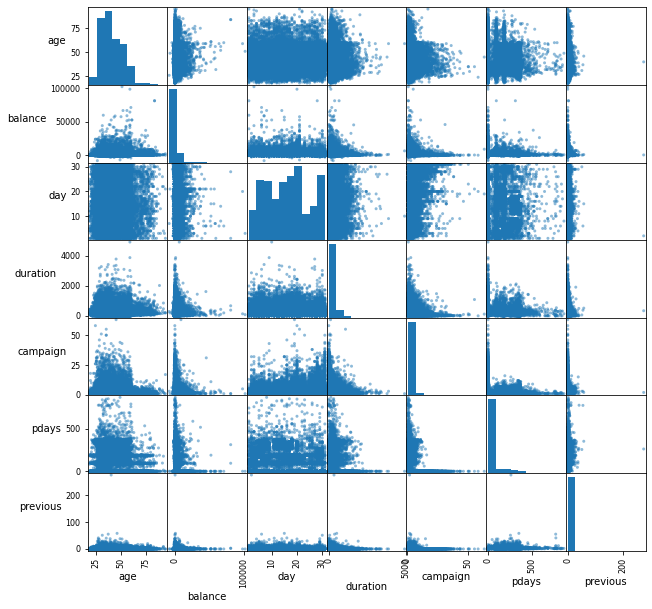

In [37]:
print('\n\nFigure 1: Pairwise scatter plot of bank-full.csv feature columns\n\t'
      '(distribution of numerical features shown as histograms along main\n\t'
      'diagonal)\n\n')

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10, 10));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    # v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(0)
    # h.set_xticks(())



Figure 2: Same matrix scatter plot as above in Fig. 1,
	but showing density plots of numerical features along main diagonal
	instead




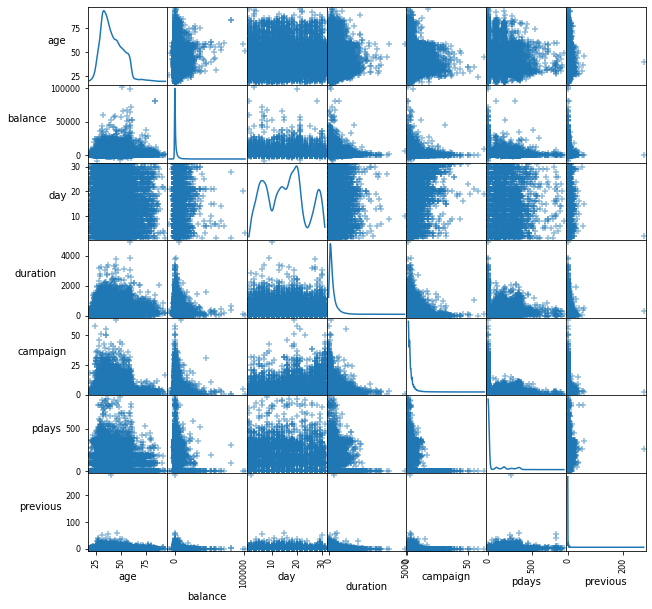

In [38]:
# let's look at a density plot instead of histogram:
print('\n\nFigure 2: Same matrix scatter plot as above in Fig. 1,\n\t'
      'but showing density plots of numerical features along main diagonal\n\t'
      'instead\n\n')

axs_2 = pd.plotting.scatter_matrix(numeric_data, diagonal='kde',
                                   marker='+', figsize=(10, 10));
n = len(numeric_data.columns)

for i in range(n):
    v = axs_2[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    # v.set_yticks(())
    h = axs_2[n - 1, i]
    h.xaxis.label.set_rotation(0)
    # h.set_xticks(())

There aren't any highly correlated variables, so we will keep them all for the model. It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, so we will remove these two columns.

8. Use the `.drop()` method to drop the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `sdf`.

    Use the `.dtypes` method to verify that `sdf` now has the correct columns.

In [39]:
# drop the month and day columns:
sdf = psdf.drop(['month', 'day'], axis=1)
sdf.dtypes

age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

In [40]:
# check dataframe type:
type(sdf)

pyspark.pandas.frame.DataFrame

In [ ]:
# has the .drop() method changed psdf in place? Ans: No:
psdf.dtypes

age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
day           int32
month        object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

In [41]:
# check dataframe type:
type(psdf)

pyspark.pandas.frame.DataFrame

## _...Let's look at the data using SweetViz_

In [42]:
# will need to convert our pandas on spark df to pandas df for SweetViz compatibility:
sdf_pd = sdf.to_pandas()

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [43]:
# check dataframe type:
type(sdf_pd)

pandas.core.frame.DataFrame

In [44]:
# install sweetviz
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 22.5 MB/s 


                                             |          | [  0%]   00:00 -> (? left)


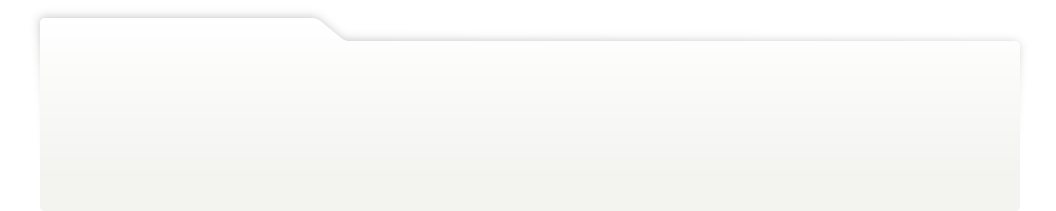
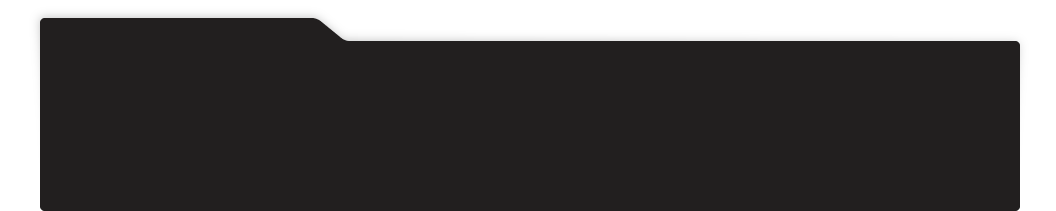
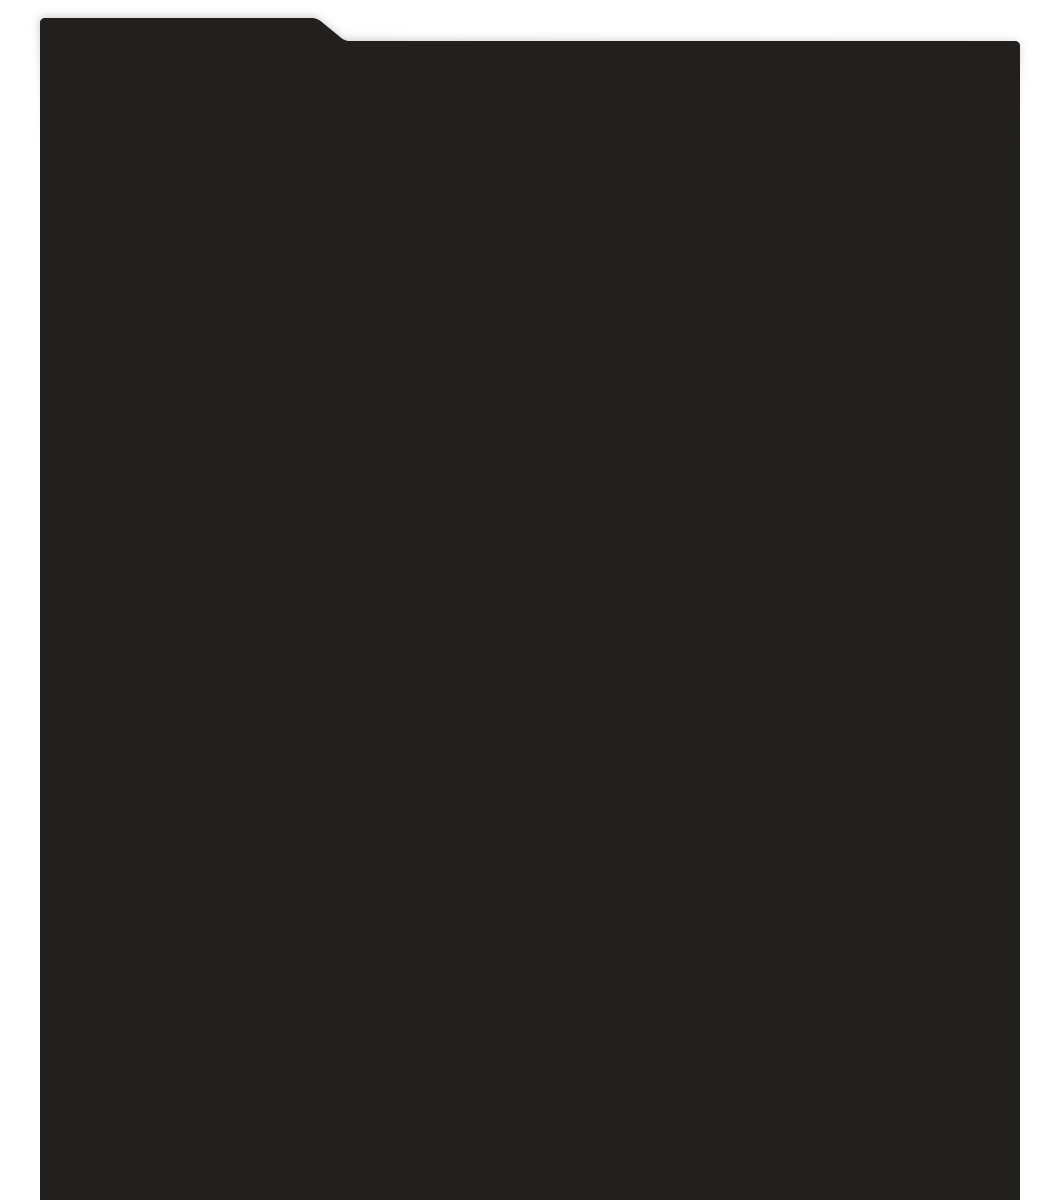
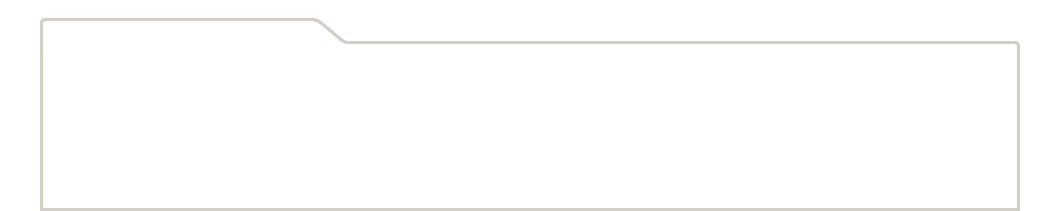
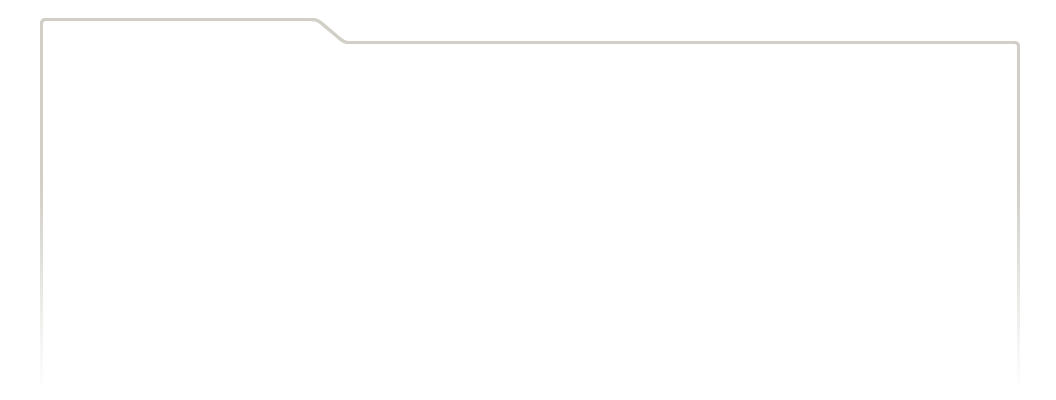
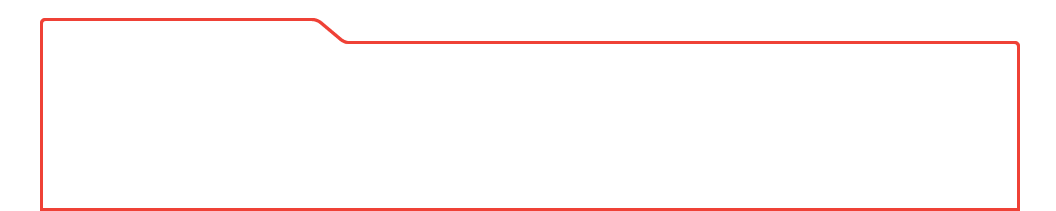
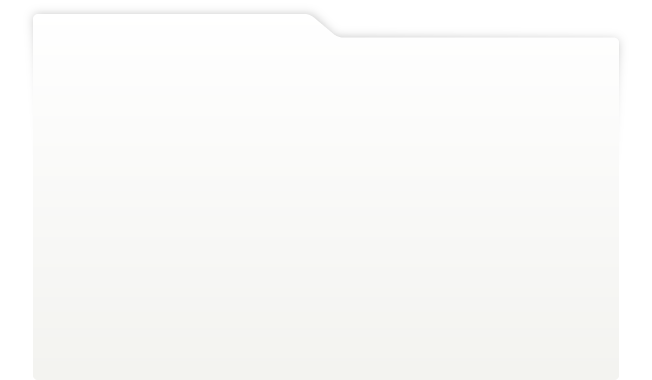
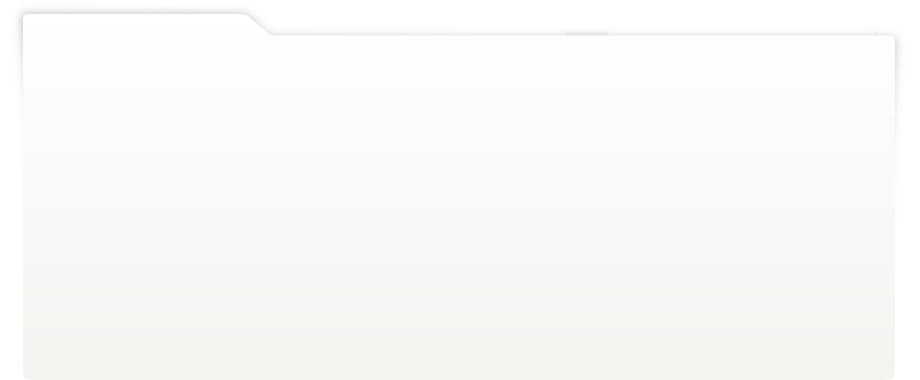
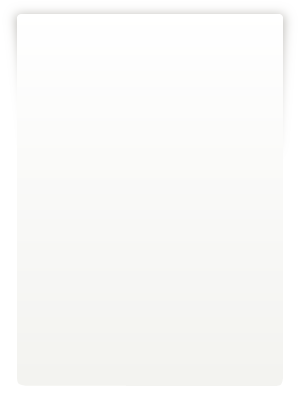
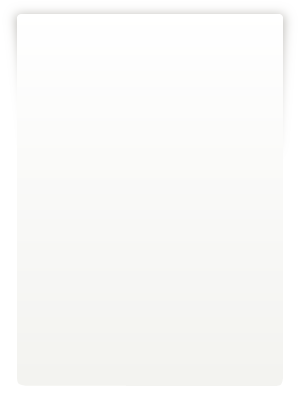
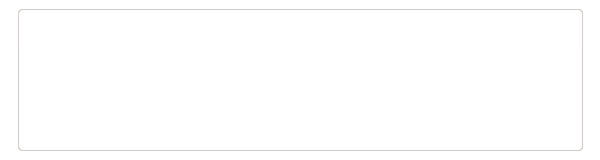
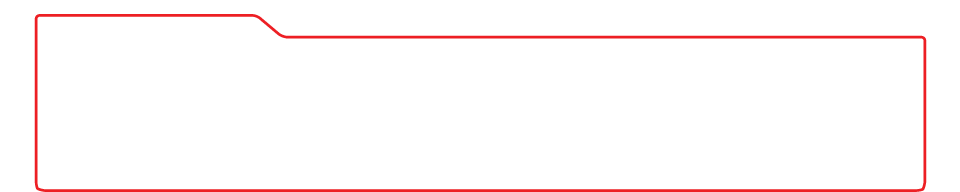
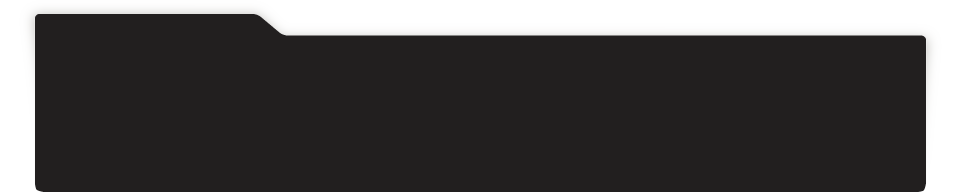
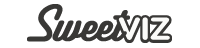
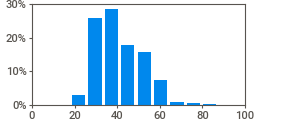
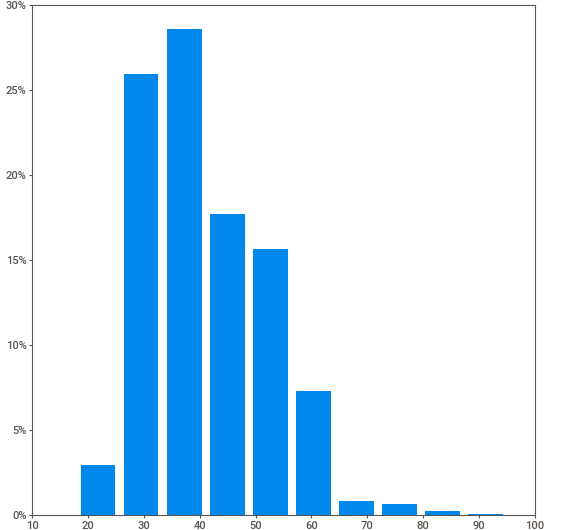
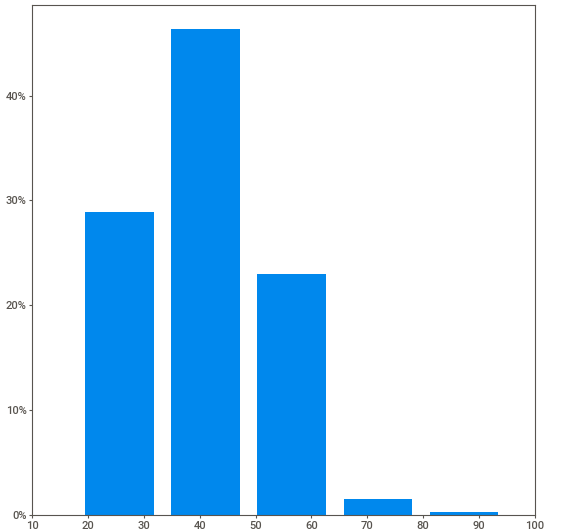
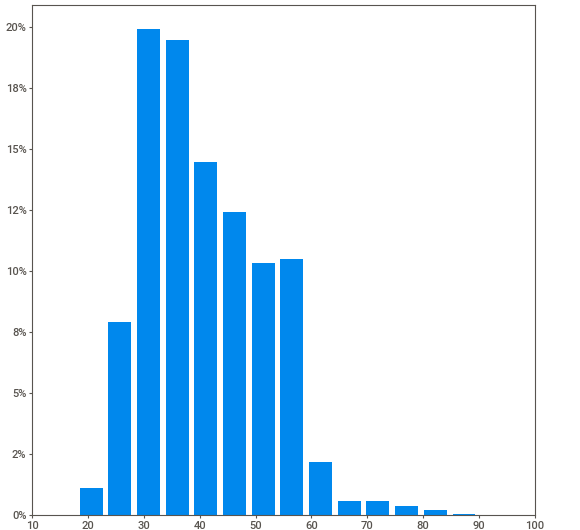
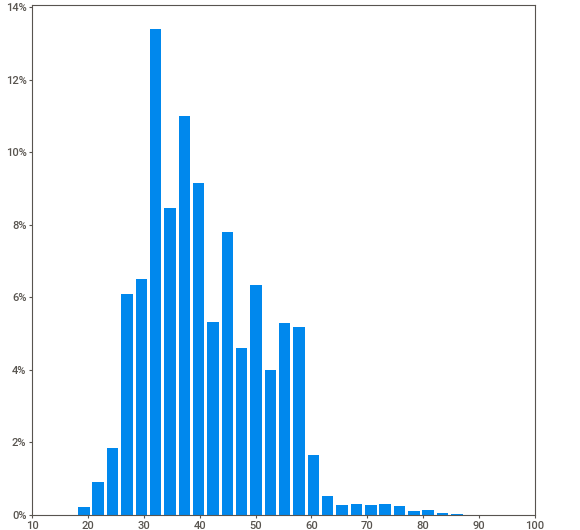
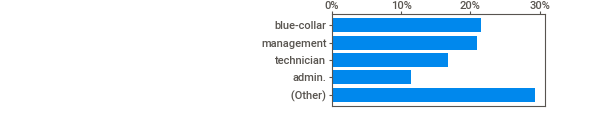
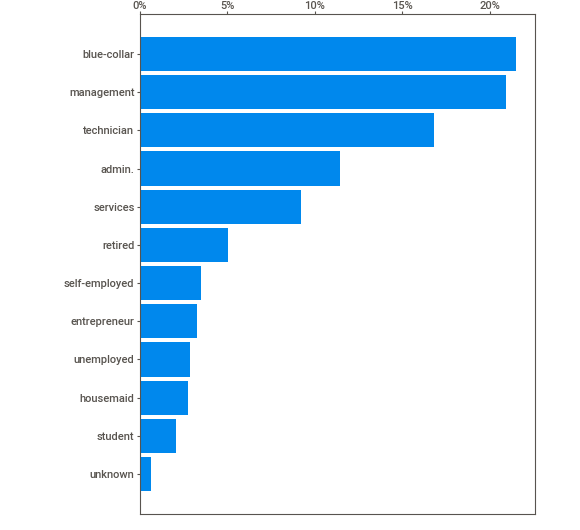
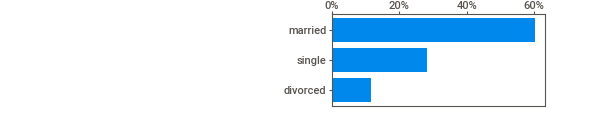
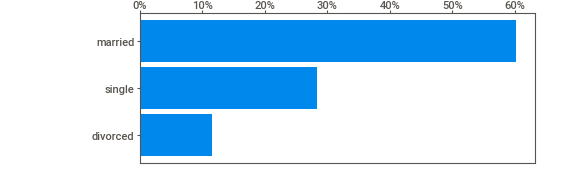
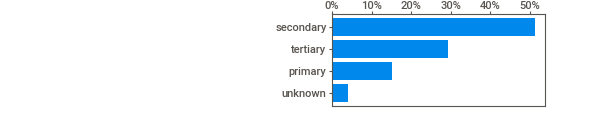
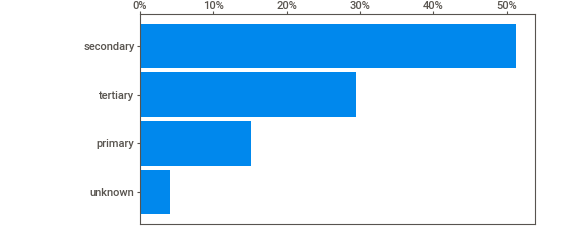
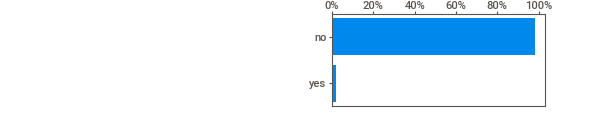
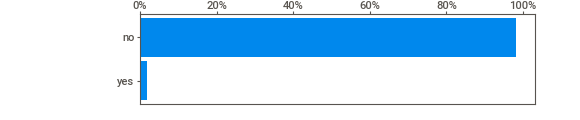
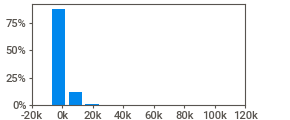
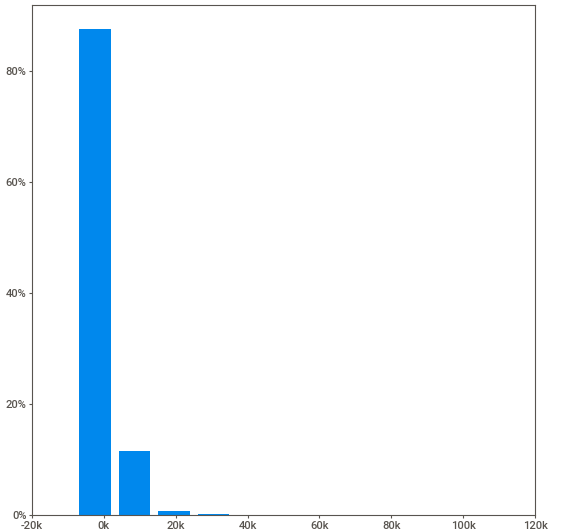
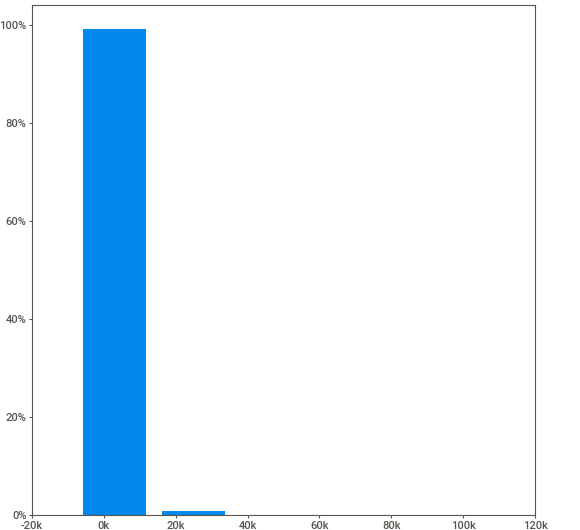
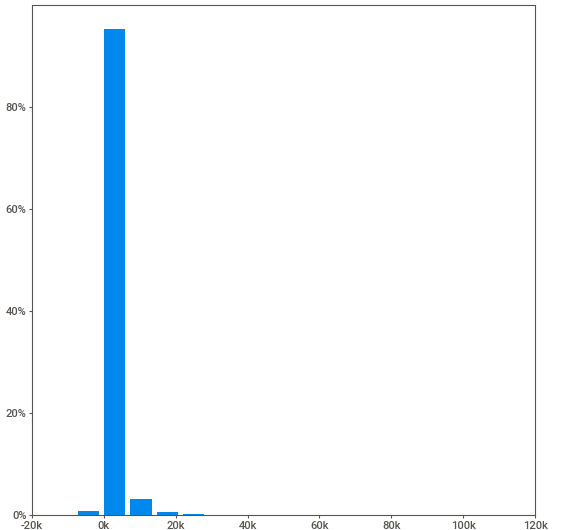
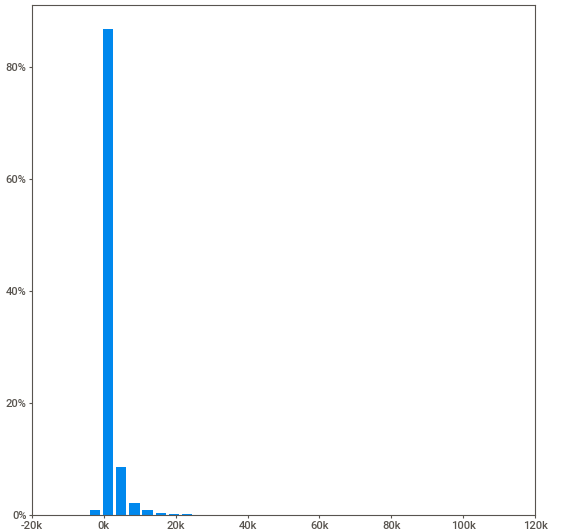
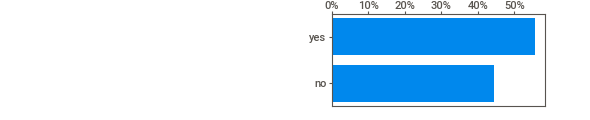
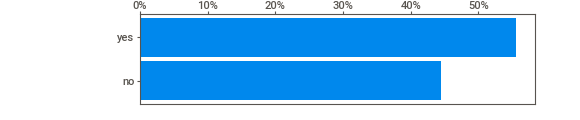
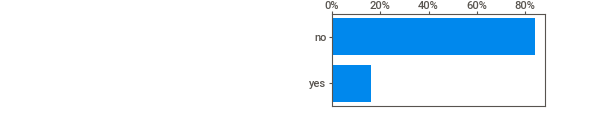
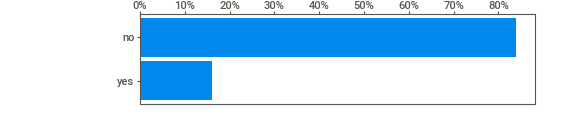
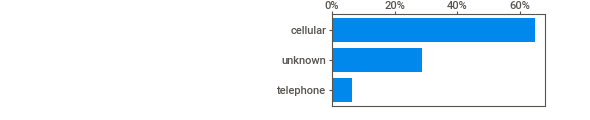
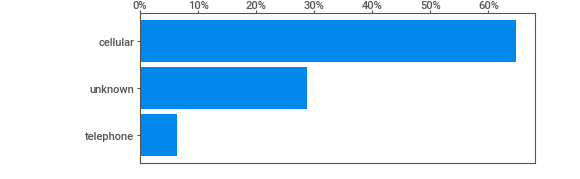
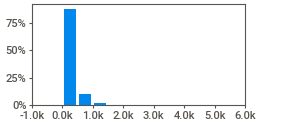
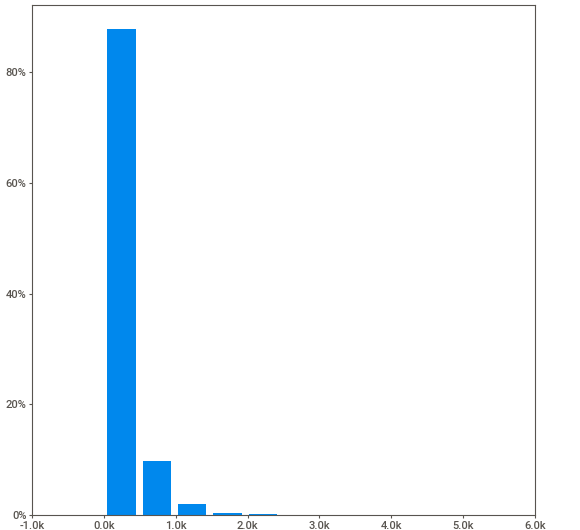
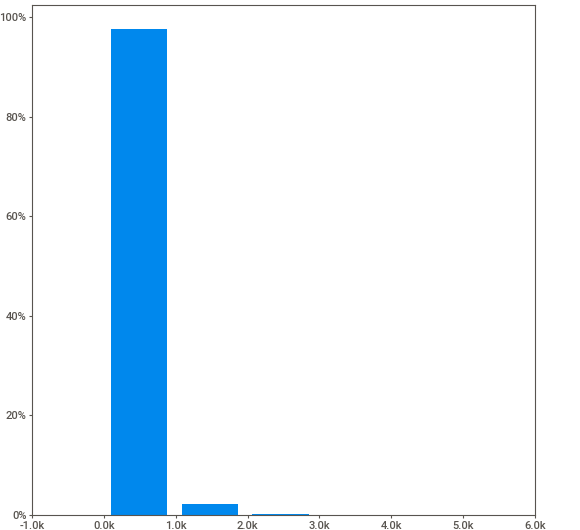
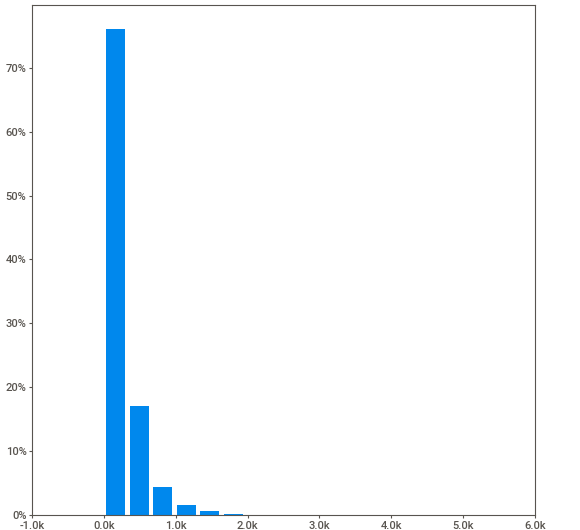
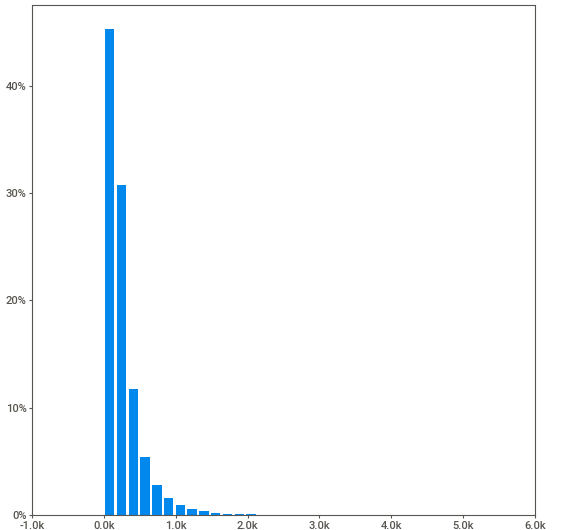
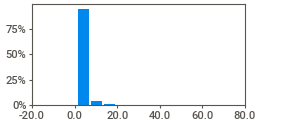
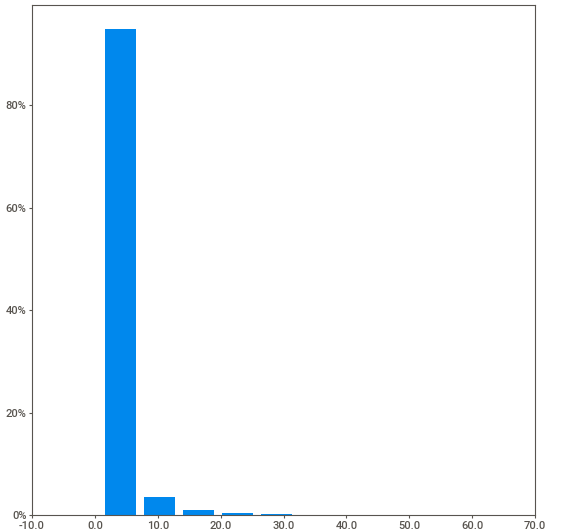
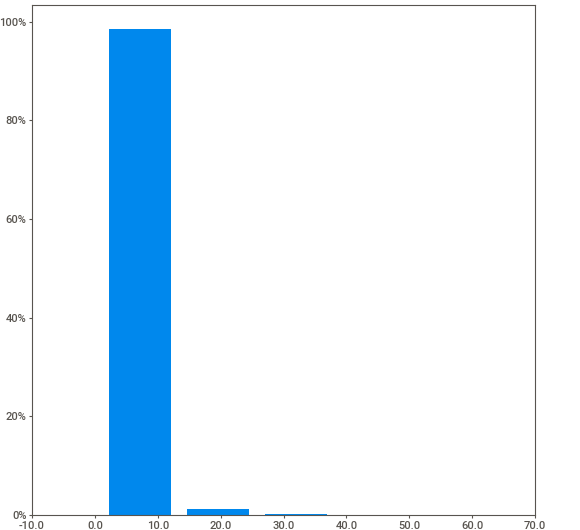
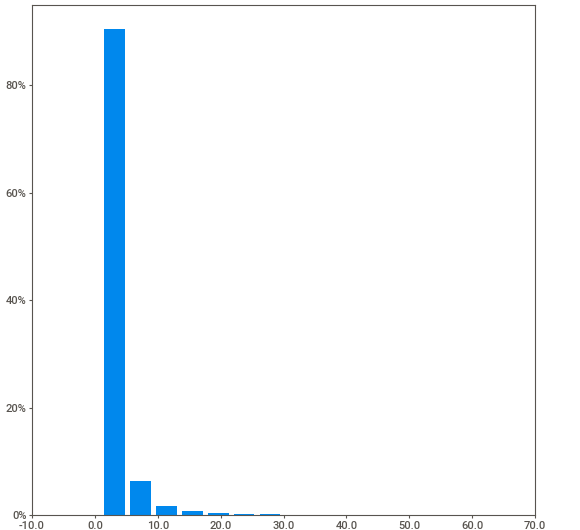
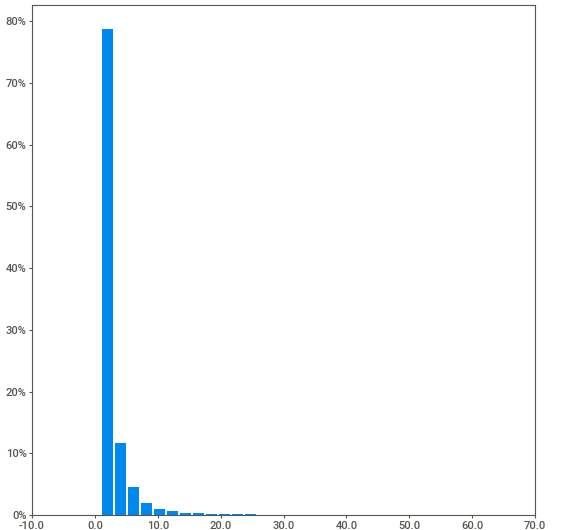
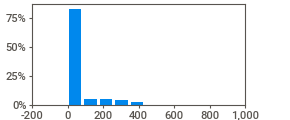
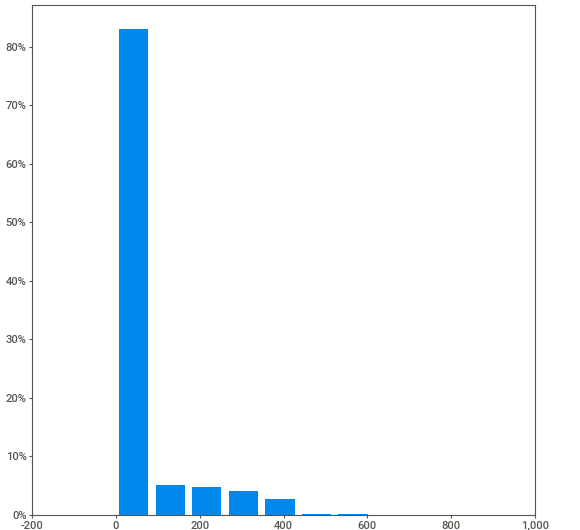
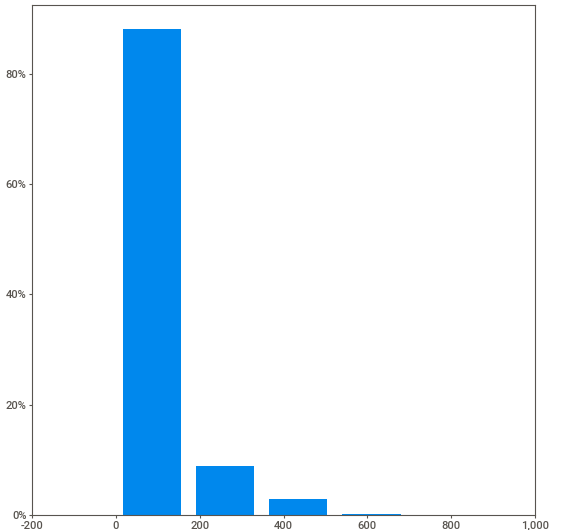
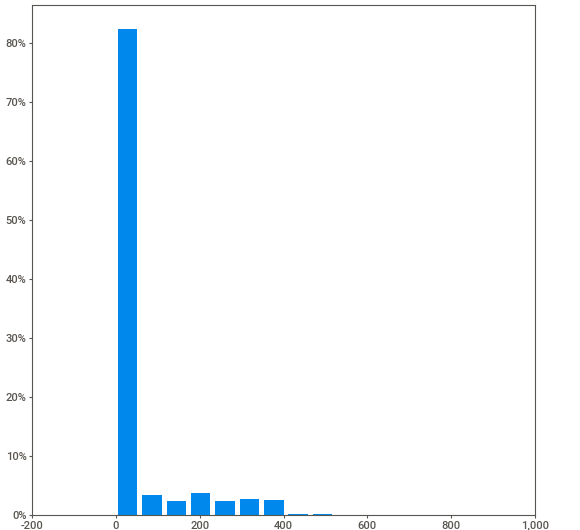
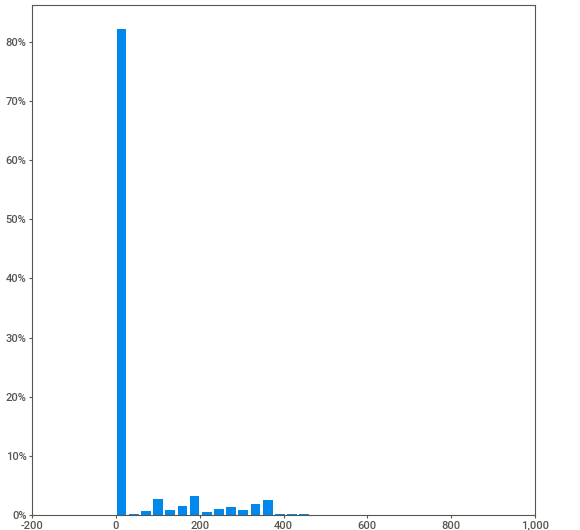
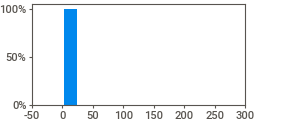
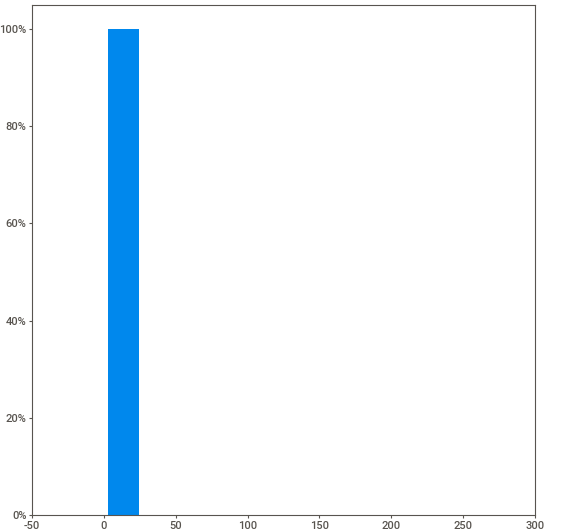
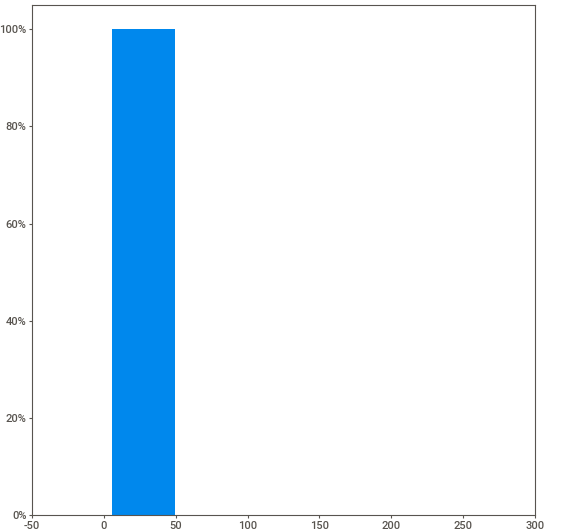
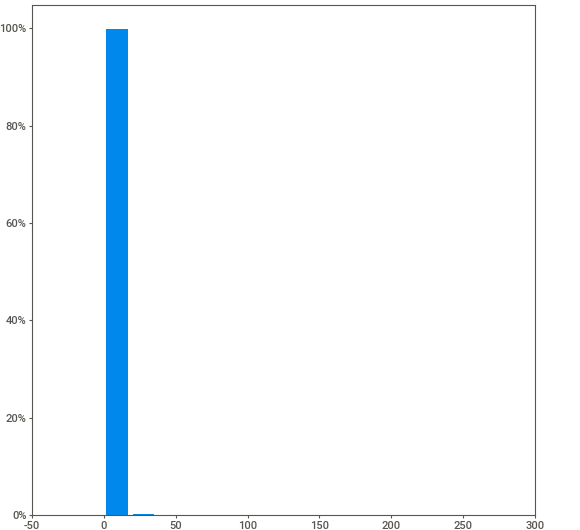
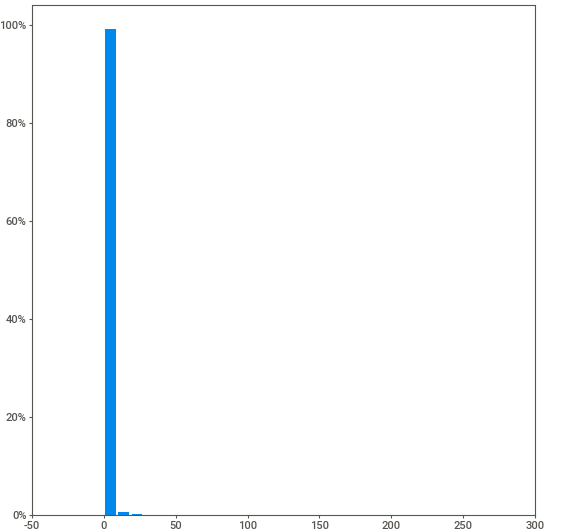
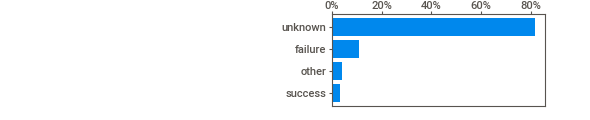
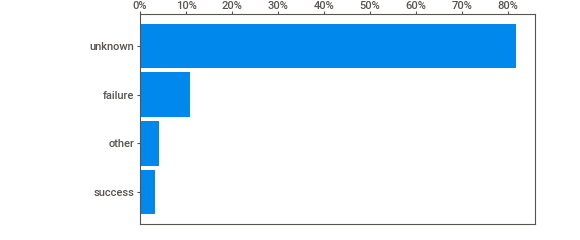
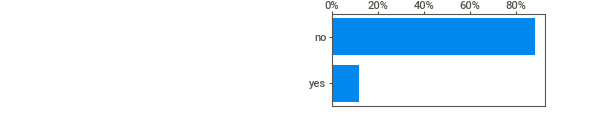
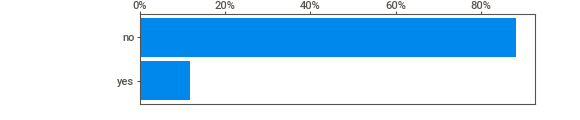
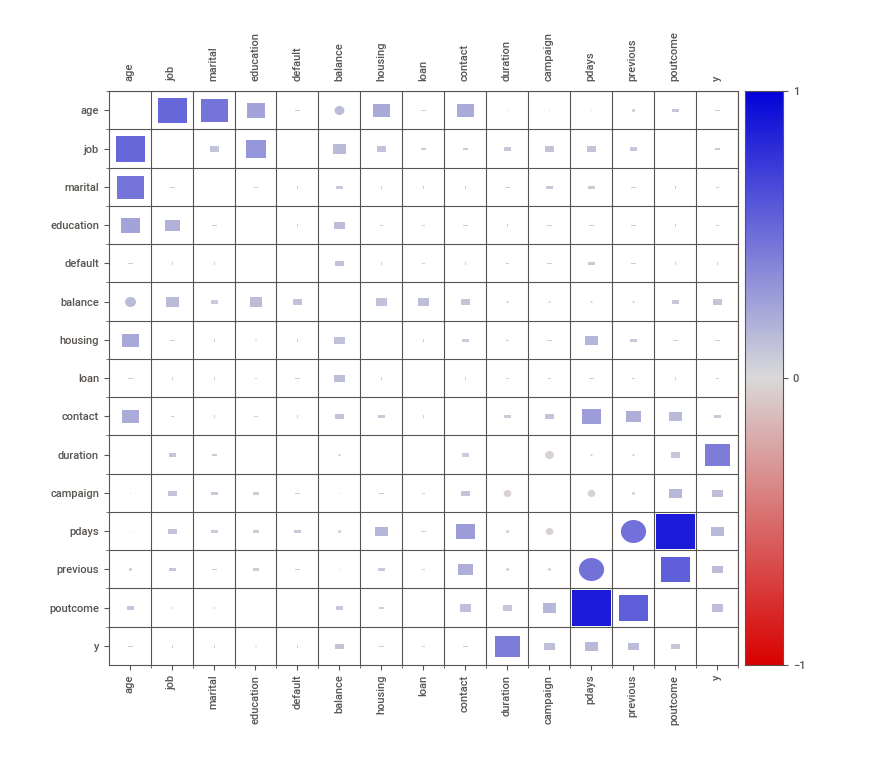
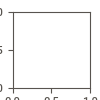

In [45]:
# generate sweetviz reports for EDA:
import sweetviz as sv

orig_data_report = sv.analyze(sdf_pd)
orig_data_report.show_notebook()

<h1><i><font color=blue>Looking at the data via SweetViz:</i>

1.   No missing values for any of the features are noted.
2.   <i>(Elementary data cleaning by a complete novice!):</i> With regard to the following specific features, we might consider:</font>
<ul><font color=blue>
<li><b>job:</b> < 1% are listed as 'unknown' → since this variable is likely contributory to the dependent variable → drop these rows (assumes that 'unknown' job status is randomly distributed with respect to the other features under consideration, in particular the target variable);
<li><b>education:</b> 4% are listed as 'unkown'; since this variable is also likely contributory to the dependent variable → drop these rows (again, assumes that 'unknown' educational status is randomly distributed with respect to the other features under consideration, in particular the target variable);
<li><b>default:</b> 98% are 'no' ⇒ unlikely to be informative (not much variance here) → drop this feature (column)
</font>
</ul>

In [46]:
# make the above adjustments to our pandas dataframe:
# check value counts for 'job' beforehand:
sdf_pd['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [47]:
# remove all rows where 'job' is listed as 'unknown':
sdf_pd = sdf_pd[sdf_pd['job'].str.contains('unknown') == False]

# now, re-check value counts for 'job':
sdf_pd['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: job, dtype: int64

In [48]:
# now, check value counts for 'education':
sdf_pd['education'].value_counts()

secondary    23131
tertiary     13262
primary       6800
unknown       1730
Name: education, dtype: int64

In [49]:
# remove all rows where 'education' is listed as 'unknown':
sdf_pd = sdf_pd[sdf_pd['education'].str.contains('unknown') == False]

# re-check value counts for 'education':
sdf_pd['education'].value_counts()

secondary    23131
tertiary     13262
primary       6800
Name: education, dtype: int64

In [50]:
# finally, drop 'default' column:
sdf_pd.drop('default', axis=1, inplace=True)

# look at descriptive stats for entire 'cleaned' pandas df:
sdf_pd.describe(include='all')

,age,job,marital,education,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
count,43193.000000,43193,43193,43193,43193.000000,43193,43193,43193,43193.000000,43193.000000,43193.000000,43193.000000,43193,43193
unique,NaN,11,3,3,NaN,2,2,3,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,NaN,yes,no,cellular,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9278,25946,23131,NaN,24292,36086,28213,NaN,NaN,NaN,NaN,35286,38172
mean,40.764082,NaN,NaN,NaN,1354.027342,NaN,NaN,NaN,258.323409,2.758178,40.404070,0.584863,NaN,NaN
std,10.512640,NaN,NaN,NaN,3042.103625,NaN,NaN,NaN,258.162006,3.063987,100.420624,2.332672,NaN,NaN
min,18.000000,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,71.000000,NaN,NaN,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,442.000000,NaN,NaN,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,1412.000000,NaN,NaN,NaN,318.000000,3.000000,-1.000000,0.000000,NaN,NaN


                                             |          | [  0%]   00:00 -> (? left)


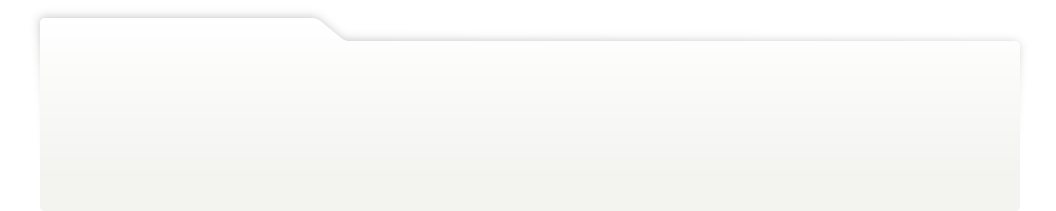
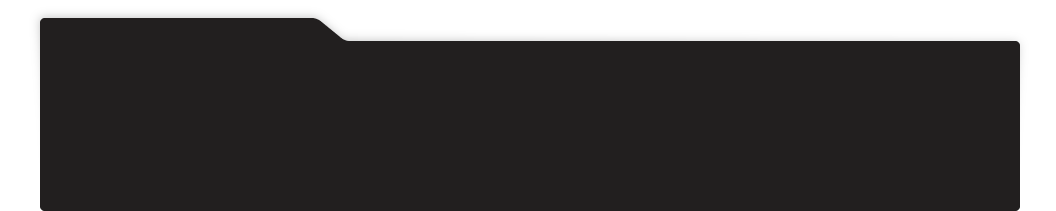
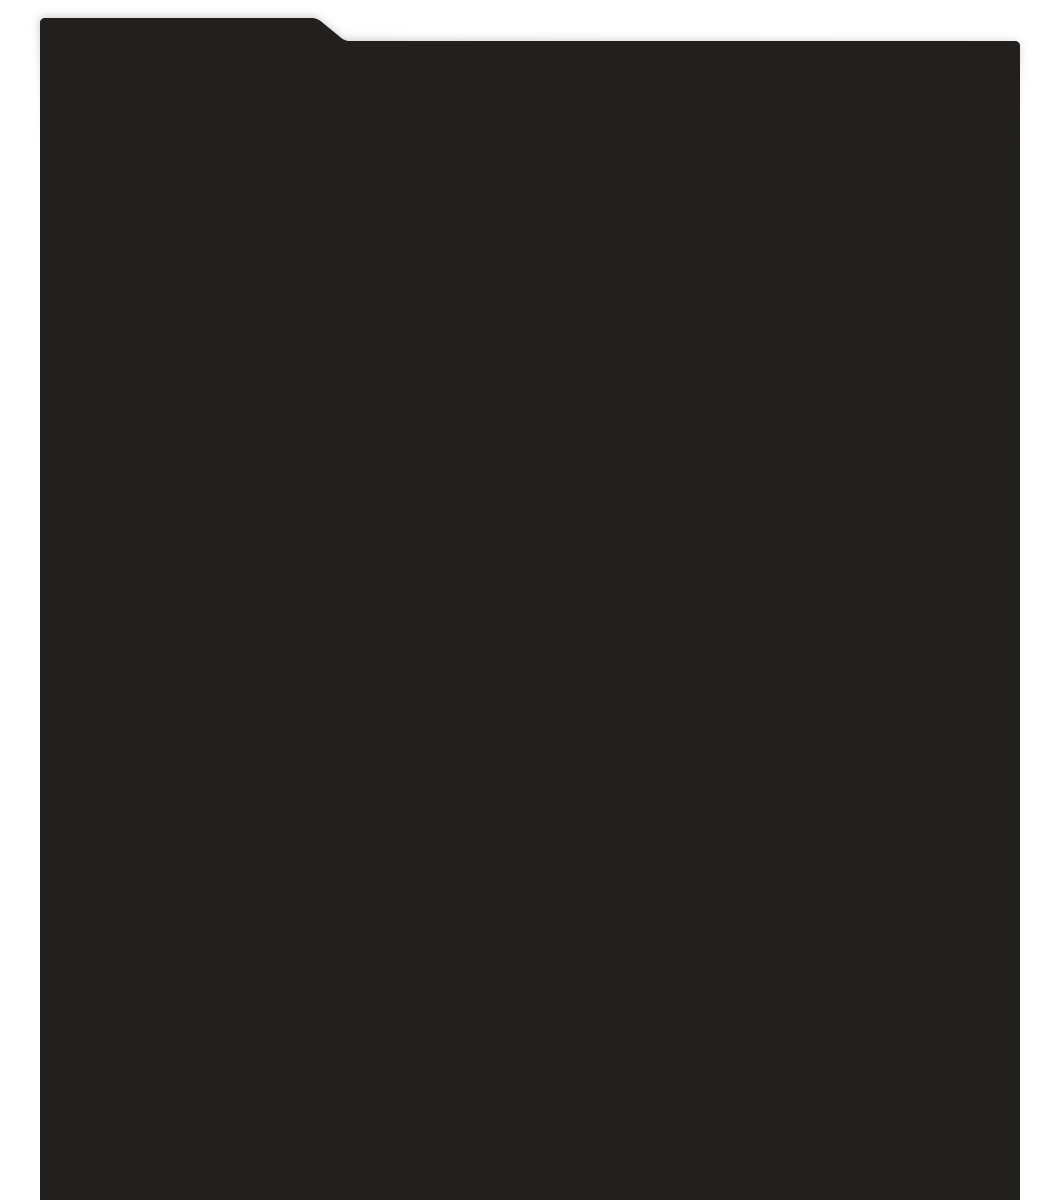
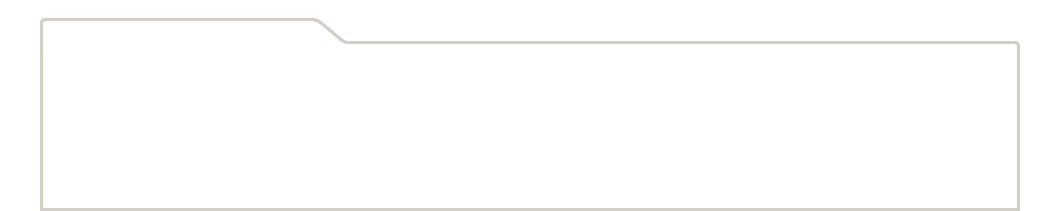
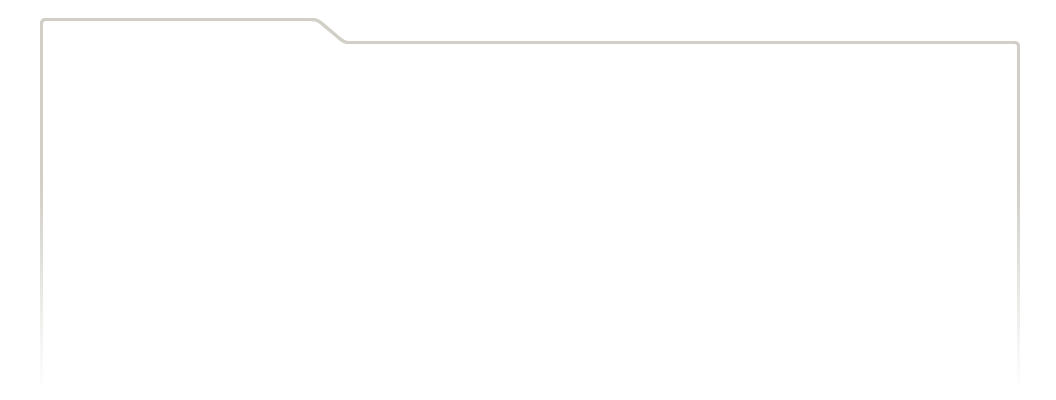
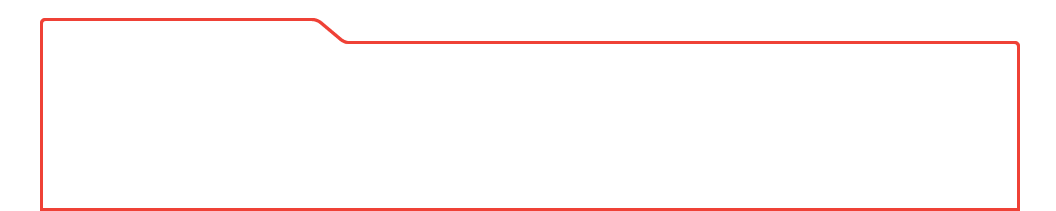
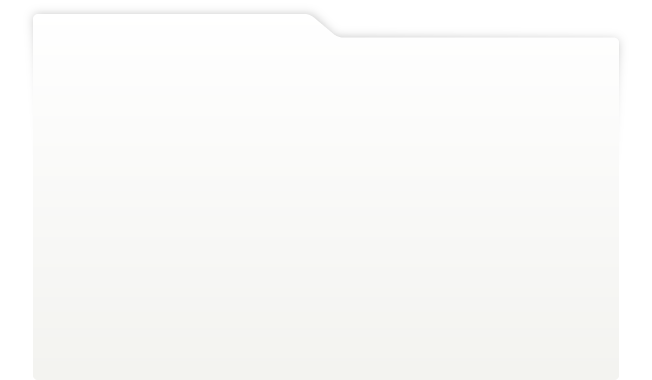
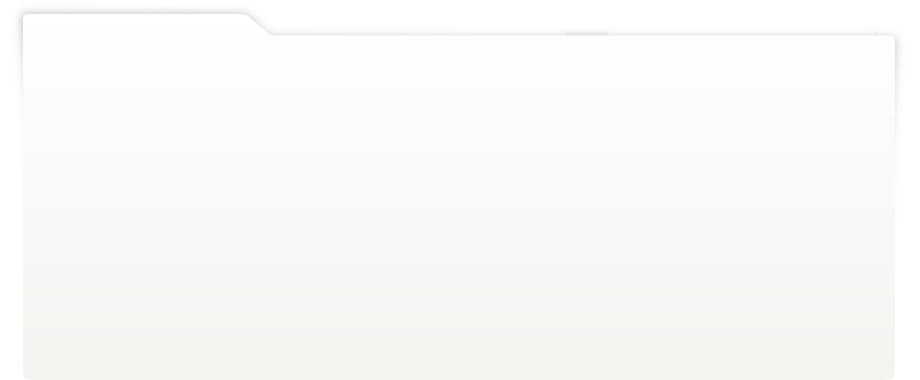
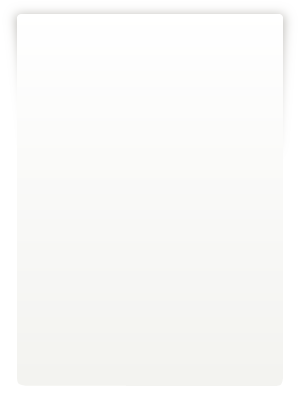
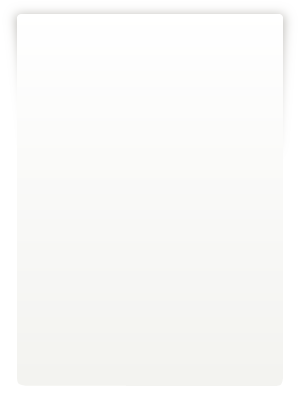
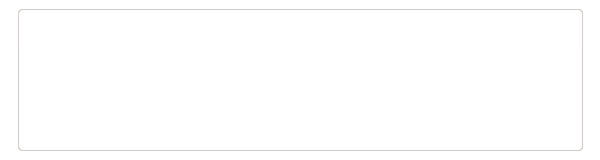
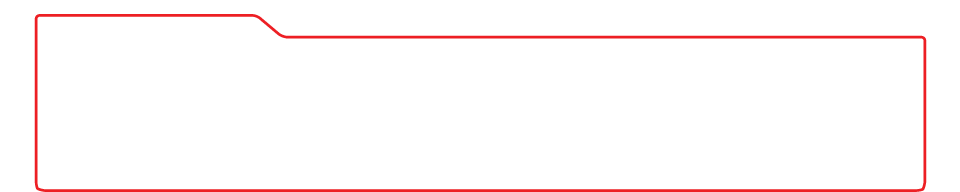
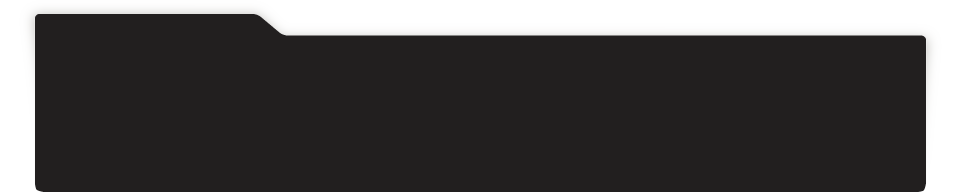
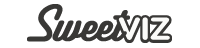
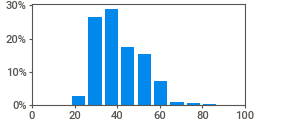
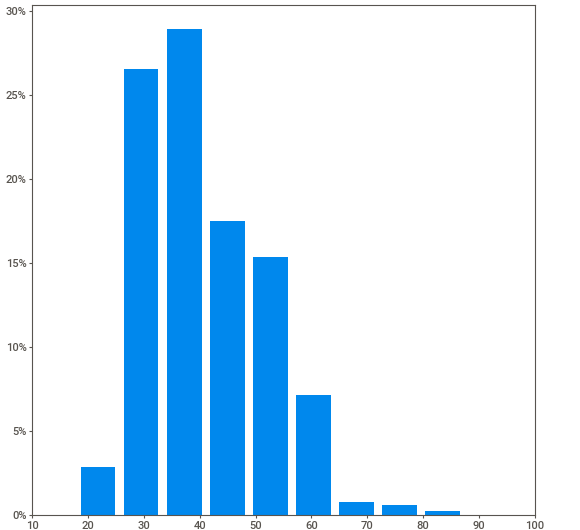
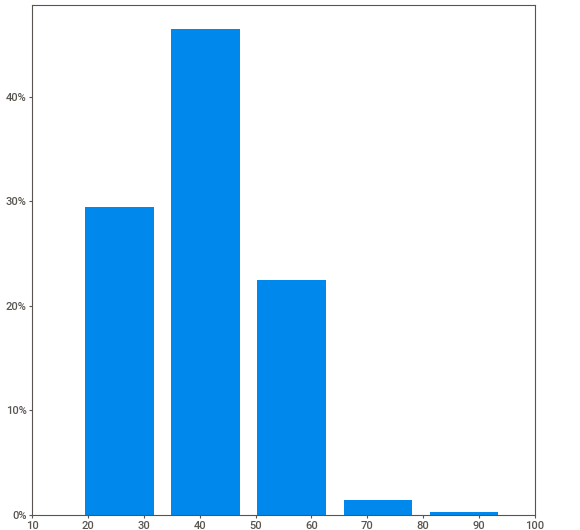
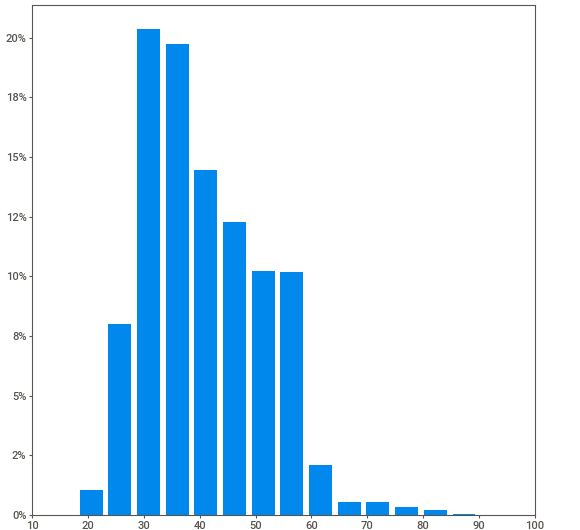
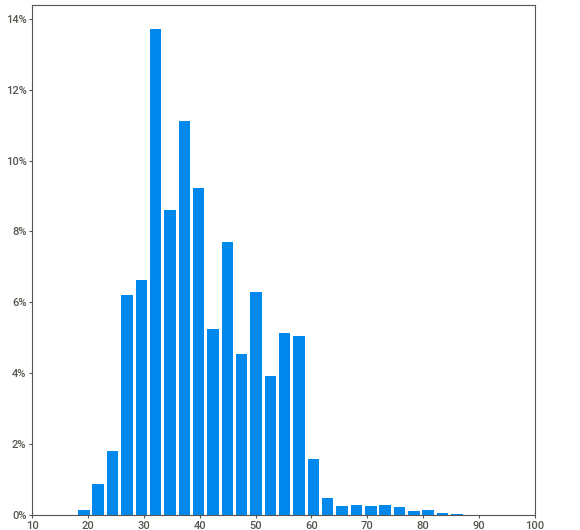
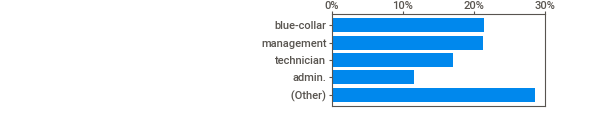
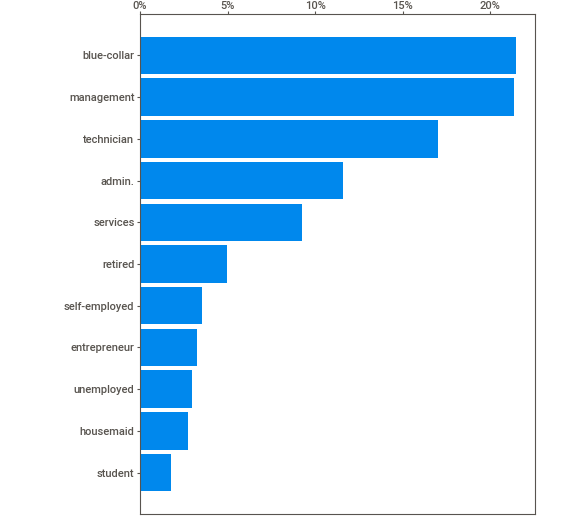
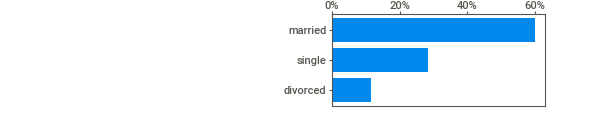
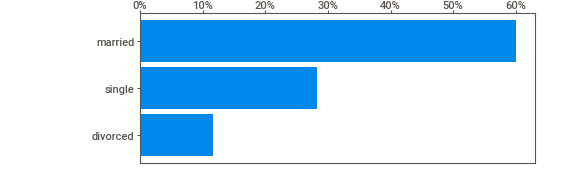
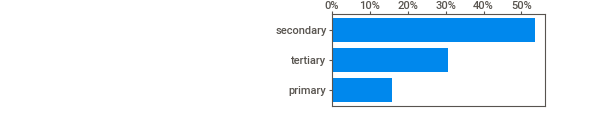
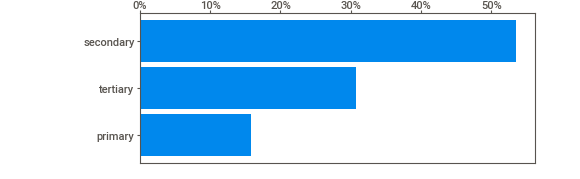
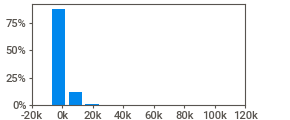
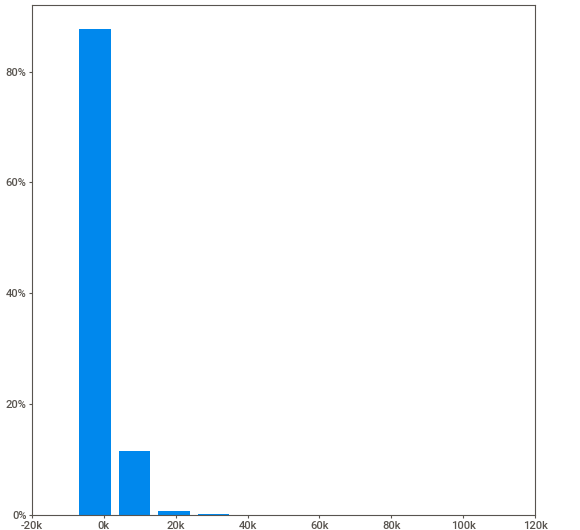
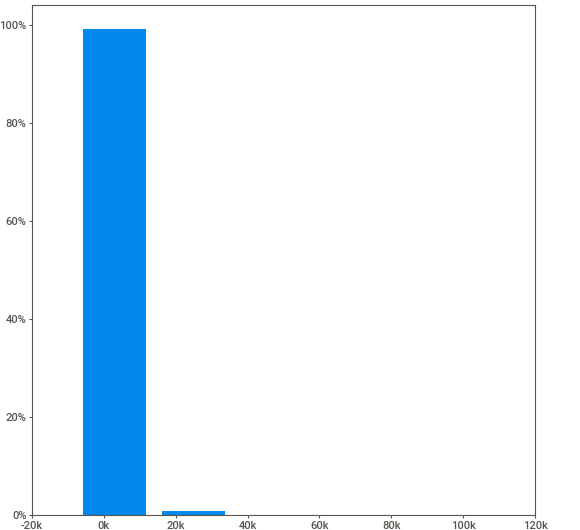
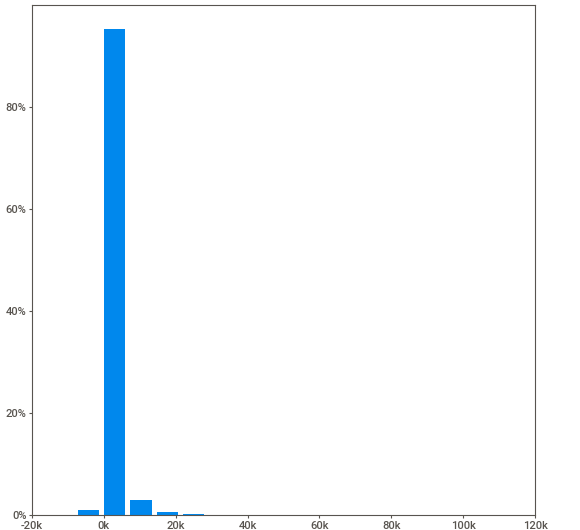
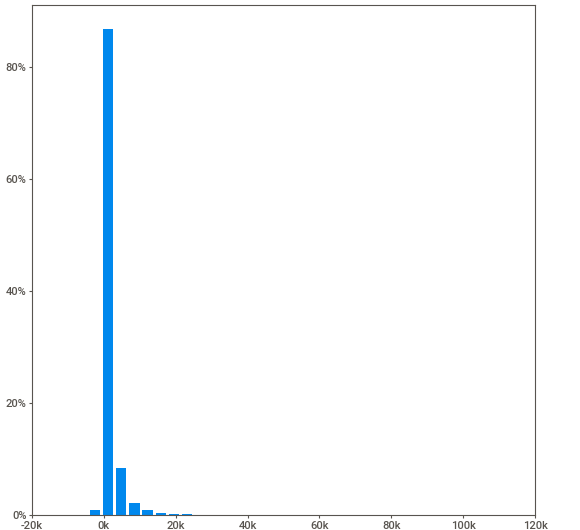
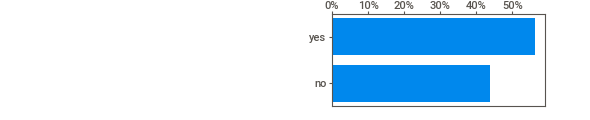
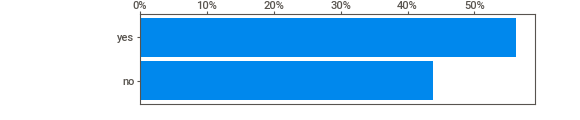
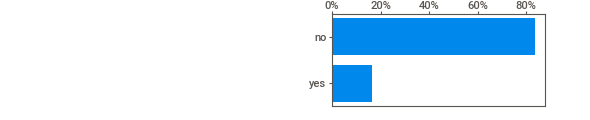
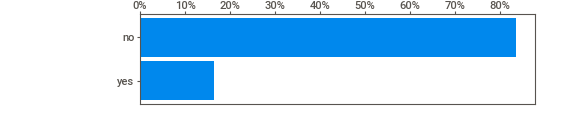
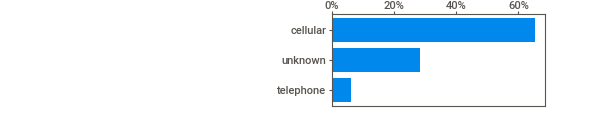
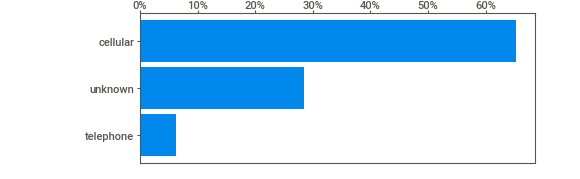
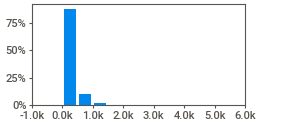
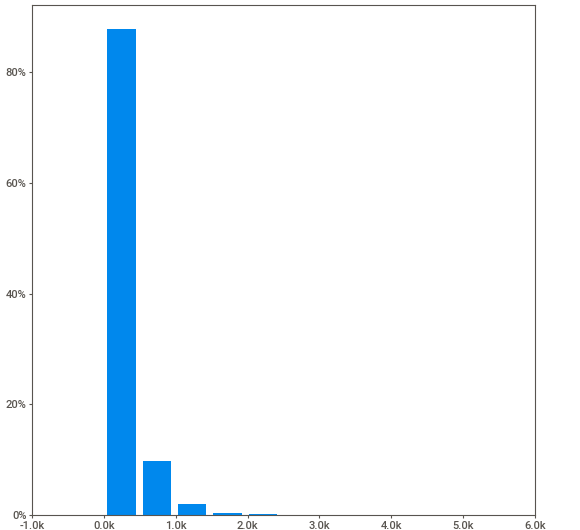
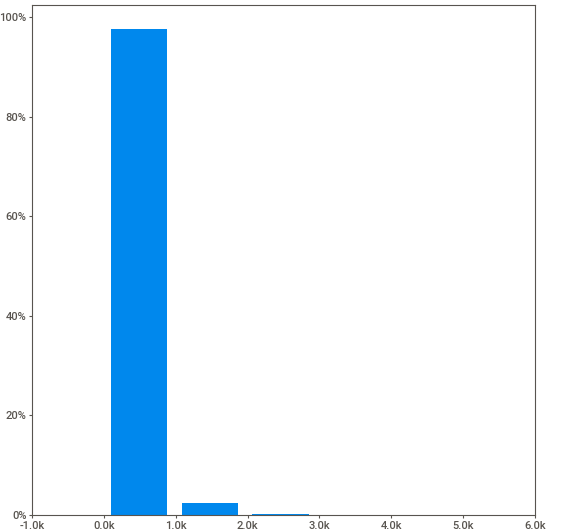
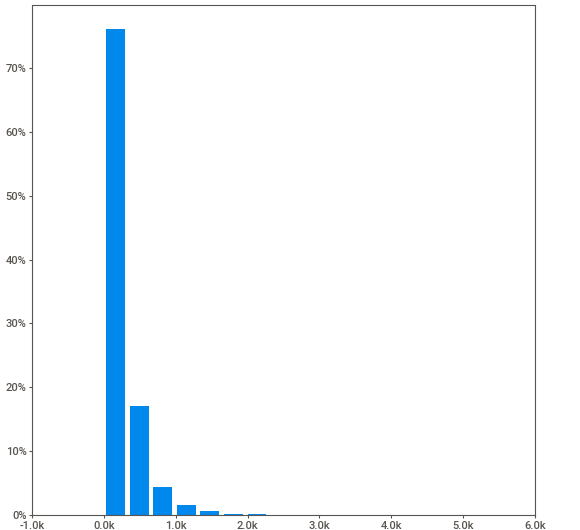
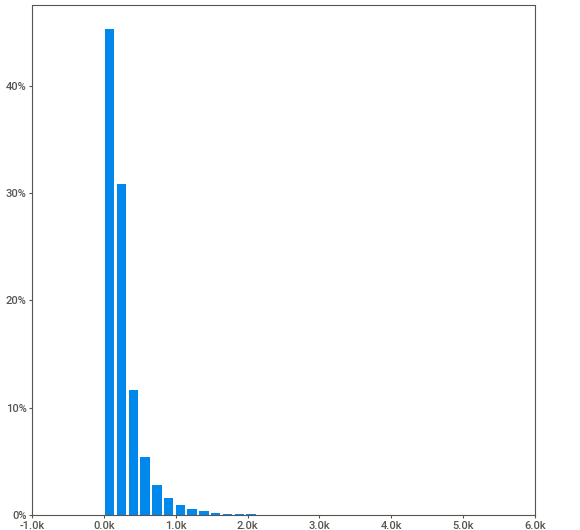
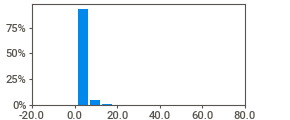
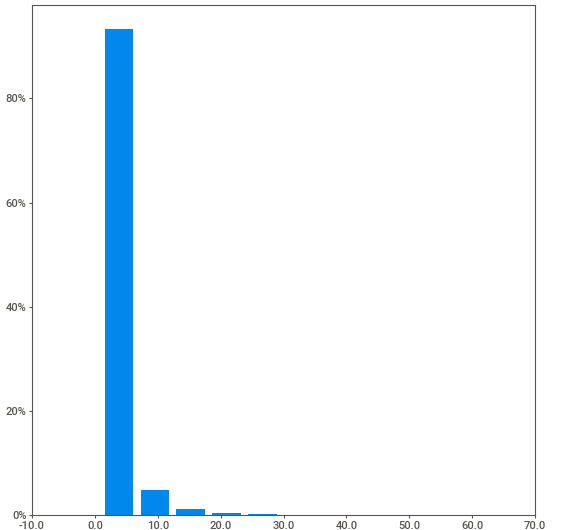
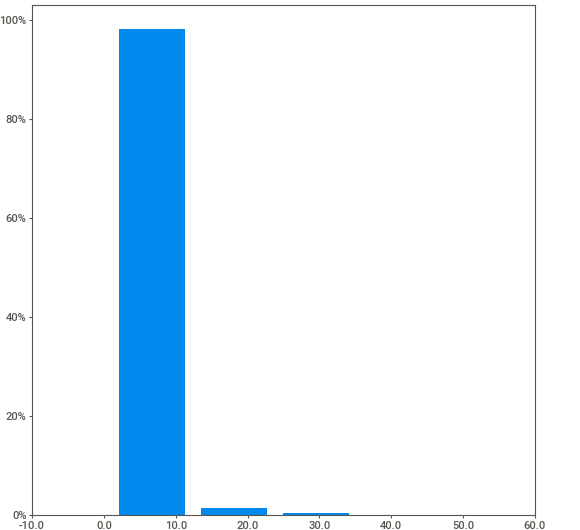
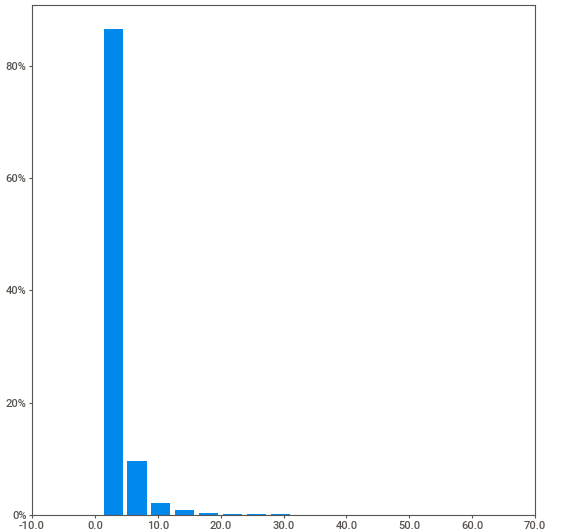
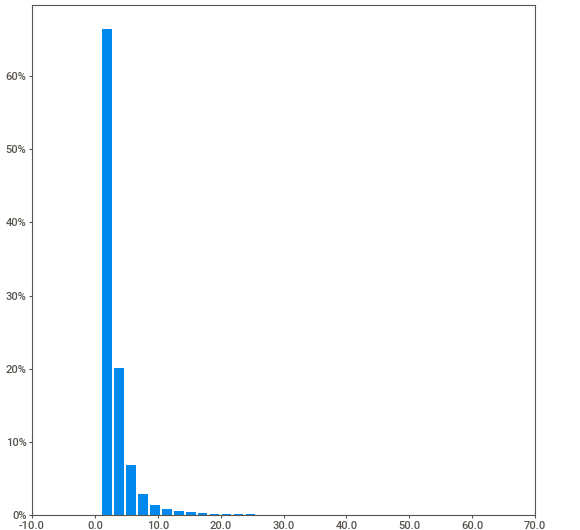
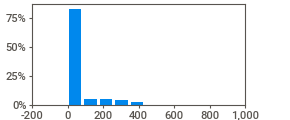
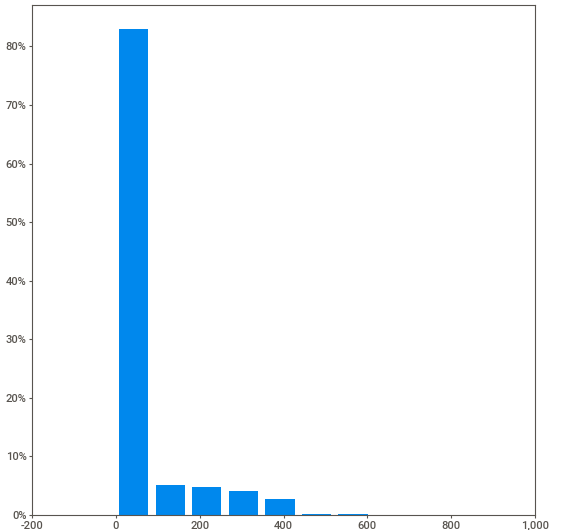
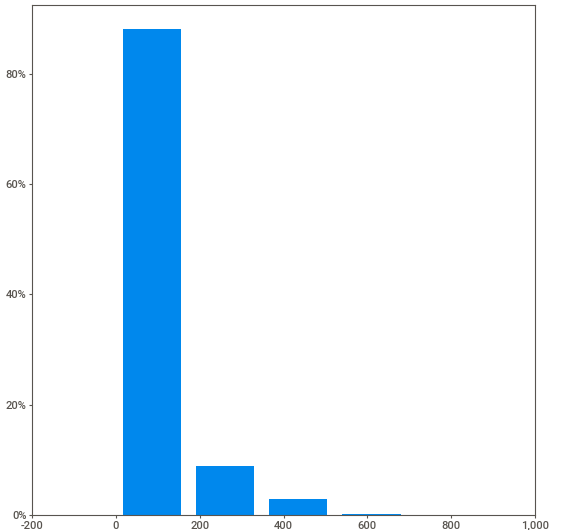
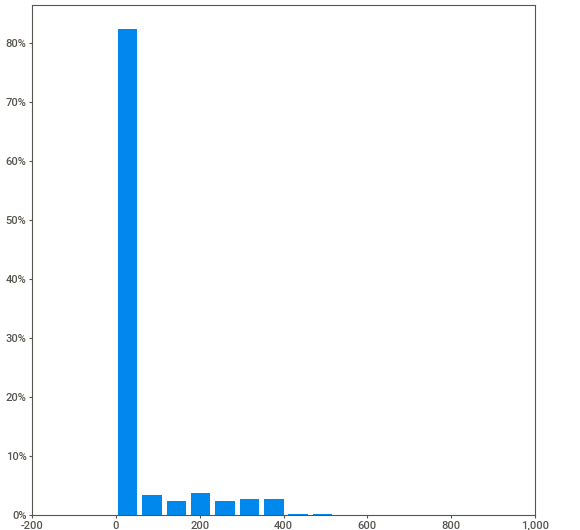
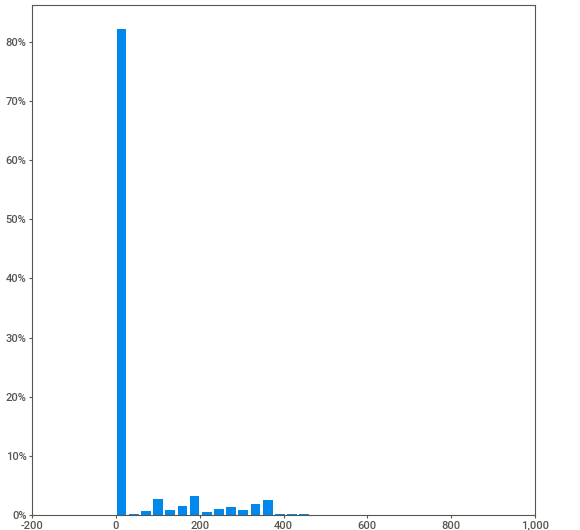
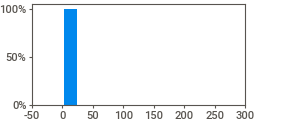
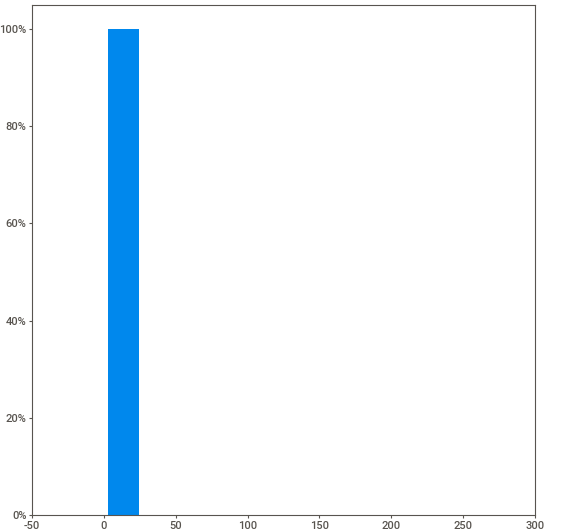
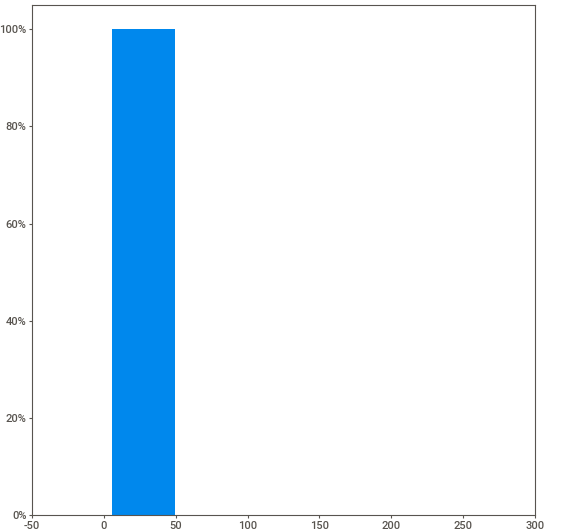
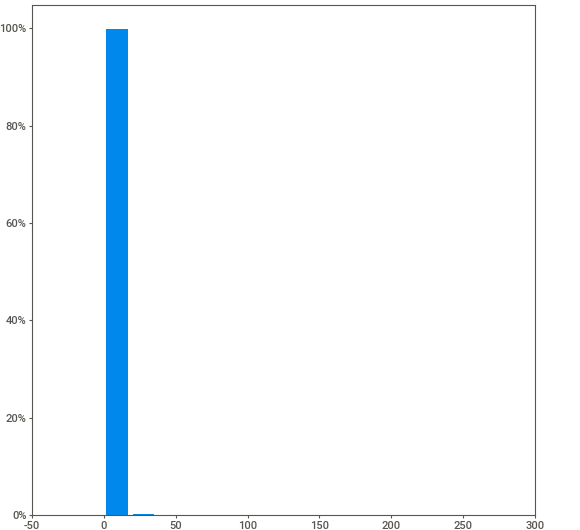
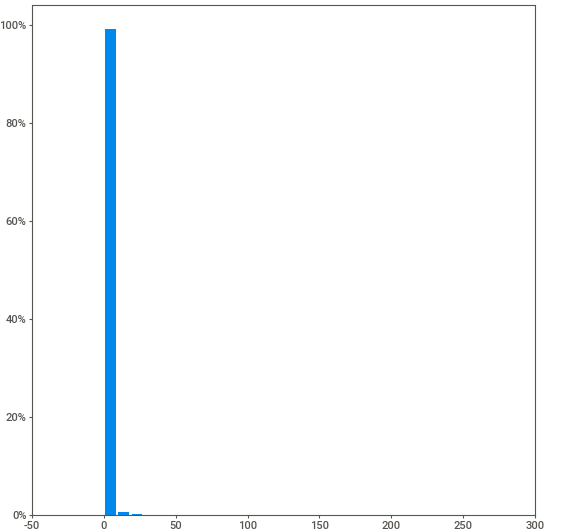
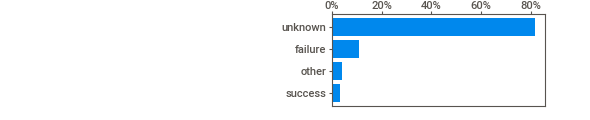
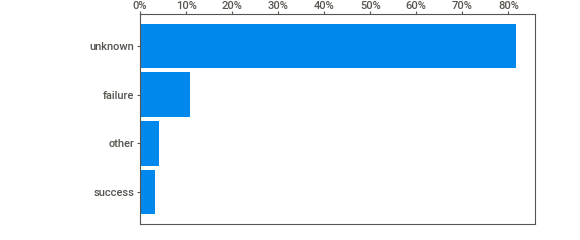
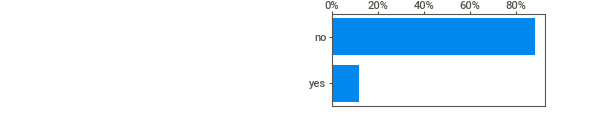
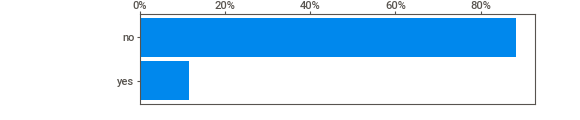
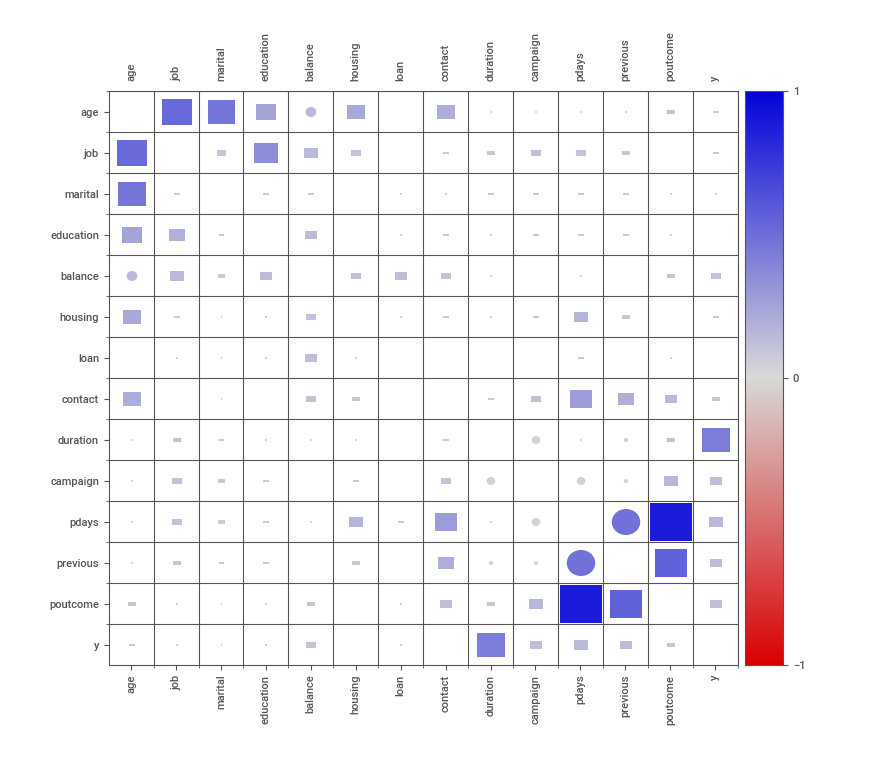
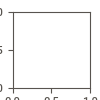

In [51]:
# double-check SweetViz report on 'cleaned' pandas df:
sdf_data_report = sv.analyze(sdf_pd)
sdf_data_report.show_notebook()

<a name='81414208434'></a>
## Part 3: Preparing Data for Machine Learning

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. The next code cell just sets this all up, but it doesn't run these transformations on our data yet.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [52]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']
# NB: removed 'default' in 'categoricalColumns list above since this column was dropped
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(
    inputCols = assemblerInputs,
    outputCol = 'features')
stages += [assembler]

## Part 4: Pipeline

<a name='7419952'></a>
We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.  So that we can run the pipeline on our Pandas on Spark DataFrame, we will convert it back to a Spark DataFrame using the **`to_spark()`** command

1. Fit a pipeline on df.

In [53]:
from pyspark.ml import Pipeline
# sdf = psdf.to_spark() 
# (original line of code above doesn't look like what we want since psdf
# still contains day & month features which were dropped in sdf);
# 
# instead, should read:
# sdf = sdf.to_spark()
#
# but, in our modified workflow above, we converted the pandas-on-spark data-
# frame 'sdf' to a pandas dataframe 'sdf_pd';
# 
# so,
# we first need to convert this back to a pyspark df:
sdf_ps = spark.createDataFrame(sdf_pd)
sdf_ps.show(12)
sdf_ps.printSchema()
sdf_ps.describe().show()

# check dataframe type:
print(f'\n\nDataframe sdf_pd is of type: \t{type(sdf_pd)}\n'
      f'Dataframe sdf_ps is of type: \t{type(sdf_ps)}')

+---+-----------+-------+---------+-------+-------+----+-------+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+----+-------+--------+--------+-----+--------+--------+---+
| 57|blue-collar|married|  primary|     52|    yes|  no|unknown|      38|       1|   -1|       0| unknown| no|
| 28|blue-collar|married|secondary|    723|    yes| yes|unknown|     262|       1|   -1|       0| unknown| no|
| 32|blue-collar| single|  primary|     23|    yes| yes|unknown|     160|       1|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|      0|    yes|  no|unknown|     226|       1|   -1|       0| unknown| no|
| 25|blue-collar|married|secondary|     -7|    yes|  no|unknown|     365|       1|   -1|       0| unknown| no|
| 54|blue-collar|married|secondary|   1291|    yes|  no|unknown|     266|       1|   -1|       0| unknown| no|
|

#### _...ok, converting from pandas dataframe sdf_pd to (py)spark dataframe sdf_ps has changed the numeric datatypes from 32-bit IntegerType to 64-bit LongType for some reason (but assume we have sufficient RAM and compute power on Colab not to worry about this...)_

In [54]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(sdf_ps)

2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [55]:
transformed_df = pipelineModel.transform(sdf_ps)
transformed_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- balance: long (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- housingIndex: double (nullable = false)
 |-- housingclassVec: vector (nullable = true)
 |-- loanIndex: double (nullable = false)
 |-- loanclassVec: vector (nullable = true)
 |-- contactIndex: doubl

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `sdf.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `sdf`.

In [56]:
selectedCols = ['label', 'features'] + sdf_ps.columns
sdf_ps = transformed_df.select(selectedCols)
sdf_ps.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- balance: long (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. Let's view the first five rows of the `sdf` DataFrame using the methods we learned in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [57]:
# using show():
sdf_ps.show(12)

# using take() & converting first 5 rows of sdf_ps to a pandas df:
sdf_ps12 = spark.createDataFrame(sdf_ps.take(12))    # .take() creates a list of rows
sdf_pd12 = sdf_ps12.toPandas()
sdf_pd12

+-----+--------------------+---+-----------+-------+---------+-------+-------+----+-------+--------+--------+-----+--------+--------+---+
|label|            features|age|        job|marital|education|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|  y|
+-----+--------------------+---+-----------+-------+---------+-------+-------+----+-------+--------+--------+-----+--------+--------+---+
|  0.0|(27,[0,10,14,15,1...| 57|blue-collar|married|  primary|     52|    yes|  no|unknown|      38|       1|   -1|       0| unknown| no|
|  0.0|(27,[0,10,12,14,1...| 28|blue-collar|married|secondary|    723|    yes| yes|unknown|     262|       1|   -1|       0| unknown| no|
|  0.0|(27,[0,11,14,17,1...| 32|blue-collar| single|  primary|     23|    yes| yes|unknown|     160|       1|   -1|       0| unknown| no|
|  0.0|(27,[0,10,12,14,1...| 59|blue-collar|married|secondary|      0|    yes|  no|unknown|     226|       1|   -1|       0| unknown| no|
|  0.0|(27,[0,10,12,14,1...| 25|bl

,label,features,age,job,marital,education,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",57,blue-collar,married,primary,52,yes,no,unknown,38,1,-1,0,unknown,no
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28,blue-collar,married,secondary,723,yes,yes,unknown,262,1,-1,0,unknown,no
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",32,blue-collar,single,primary,23,yes,yes,unknown,160,1,-1,0,unknown,no
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,blue-collar,married,secondary,0,yes,no,unknown,226,1,-1,0,unknown,no
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25,blue-collar,married,secondary,-7,yes,no,unknown,365,1,-1,0,unknown,no
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,blue-collar,married,secondary,1291,yes,no,unknown,266,1,-1,0,unknown,no
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",57,blue-collar,married,primary,249,yes,no,unknown,164,1,-1,0,unknown,no
7,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,blue-collar,single,secondary,12223,yes,yes,unknown,177,1,-1,0,unknown,no
8,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",57,blue-collar,married,secondary,5935,yes,yes,unknown,258,1,-1,0,unknown,no
9,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55,blue-collar,married,primary,23,yes,no,unknown,291,1,-1,0,unknown,no


In [58]:
# let's check to see how balanced the binary label classes are in this dataset:
sdf_ps.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|38172|
|  1.0| 5021|
+-----+-----+



#### _NB: The above table shows that the label classes are moderately imbalanced in our dataset for binary classification, but not severely so, viz. ratio of negatives to positives_ __`= 38,172/5,021 ≈ 7.6:1`__

5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [59]:
train, test = sdf_ps.randomSplit(weights = [0.7, 0.3], seed=46)

6. What are the sizes of the training and test sets?

In [60]:
print(f'size of train = \t{train.count()}\n'
      f'size of test  = \t{test.count()}')

size of train = 	30185
size of test  = 	13008


## Part 5: Logistic Regression Model

- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a LogisticRegression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [61]:
from pyspark.ml.classification import LogisticRegression

# define LogisticRegression object:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

# fit logistic regression model on training data:
lrModel = lr.fit(train)

2. We can obtain the coefficients by using LogisticRegressionModel’s attributes. Look at the following plot of the beta coefficients.

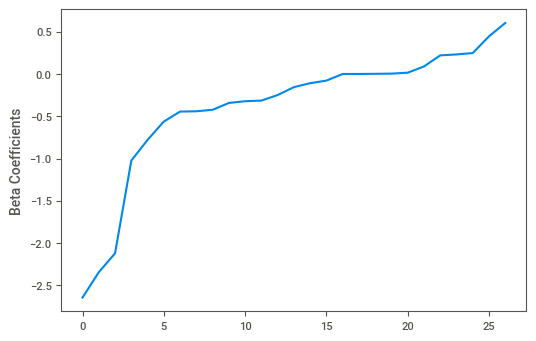

In [62]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [63]:
predictions = lrModel.transform(test)

4. View the first 10 rows of the `predictions` DataFrame.

In [64]:
predictions.show(10)

+-----+--------------------+---+-----------+-------+---------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|label|            features|age|        job|marital|education|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|  0.0|(27,[0,10,12,14,1...| 25|blue-collar|married|secondary|    148|    yes|  no|cellular|     119|       1|   -1|       0| unknown| no|[3.52240575129837...|[0.97131860140756...|       0.0|
|  0.0|(27,[0,10,12,14,1...| 27|blue-collar|married|secondary|    556|    yes|  no|cellular|      11|       7|   -1|       0| unknown| no|[4.59581559267646...|[0.99000688550352...|       0.0|
|  0.0|(27,[0,10,12,14,1...| 28|blue-col

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
AUC_lr_test = evaluator.evaluate(predictions)
print(f'The AUC using logistic regression on test is: {AUC_lr_test:.4f}')


The AUC using logistic regression on test is: 0.8823


## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [66]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
AUC_gbt_test = evaluator.evaluate(predictions)
print(f'The AUC using gbtModel on test is: {AUC_gbt_test:.4f}')

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 25|blue-collar|  0.0|[1.12781631009290...|       0.0|[0.90513528719062...|
| 27|blue-collar|  0.0|[1.28058641571886...|       0.0|[0.92832053893301...|
| 28|blue-collar|  0.0|[1.20604580154587...|       0.0|[0.91774471366237...|
| 28|blue-collar|  0.0|[0.81888265958024...|       0.0|[0.83723063462271...|
| 28|blue-collar|  0.0|[1.20500967021093...|       0.0|[0.91758814440933...|
| 28|blue-collar|  0.0|[0.86283273241612...|       0.0|[0.84885714558065...|
| 29|blue-collar|  0.0|[1.20604580154587...|       0.0|[0.91774471366237...|
| 29|blue-collar|  0.0|[1.28280018718725...|       0.0|[0.92861459621902...|
| 29|blue-collar|  0.0|[1.26137348606882...|       0.0|[0.92572116176888...|
| 29|blue-collar|  0.0|[0.86283273241612...|       0.0|[0.84885714558065...|

2. Run some cross validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [67]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
AUC_cv_test = evaluator.evaluate(predictions)
print(f'The AUC using cvModel on test is: {AUC_cv_test:.4f}')

The AUC using cvModel on test is: 0.8930


# ___Rubric Questions___

## _1. Algorithm Understanding:_
_How does the Gradient-Boosted Tree Algorithm work in Classification? How does Gradient Boost differ from AdaBoost and Logistic Regression?_

*   The __Gradient-Boosted Tree (GBT) Algorithm__ is a commonly used _boosting algorithm,_ that is, an _ensemble method_ (group of predictors) which combines several 'weak' learners into a 'strong' learner by sequentially training predictors, such that each predictor tries to correct its predecessor. In GBT, each new, sequentially trained predictor (typically a _decision tree_) is fit to the _residual errors_ made by the previous predictor. Ultimately, predictions on new instances are made by summing the predictions of the ensemble of trees. By the nature of its design, this approach is _sensitive to outliers_ as well as _prone to overfitting if the ensemble of trees is too large._
*   GBT differs from another common form of boosting, __AdaBoost.__ The latter also sequentially adds predictors to an ensemble, such that each new predictor attempts to correct its predecessor; however AdaBoost focuses on wrong predictions ('harder' cases) by increasing their relative weights before training the next predictor, which thus exhibits improved performance on its predecessor's mistakes.
*   In contrast to the above, __logistic regression__ is not a boosting algorithm (ensemble method combining sequentially trained predictors, in which each predictor tries to correct its predecessor), but rather consists of a single predictor, whose parameters are interatively optimized with respect to a defined cost function by e.g. gradient descent.

## _2. Interview Readiness:_


### _a. What is a Delta Lake and how does it offer a solution to building reliable data pipelines?_

A __Delta Lake__ is an open source storage layer running on top of your existing data lake that offers a solution to building reliable data pipelines by providing:


*   ACID transactions written to a log as a 'single source of truth'
*   scalable metadata handling (terabytes to petabytes of data)
*   unified batch & streaming (even concurrent)
*   schema enforcement, preventing 'bad' writes
*   time travel (data versioning)
*   easy upserts, merges, and deletes
*   complete compatibility with Apache Spark

### _b. When working with Pandas, we use the class pandas.core.frame.DataFrame and when working with the pandas API in Spark, we use the class pyspark.pandas.frame.DataFrame. Are these the same; explain why or why not?_

No, these are not the same. Class pandas.core.frame.Dataframe describes pandas dataframe objects while class pyspark.pandas.frame.Dataframe describes pandas-on-spark dataframes. We saw the importance of this difference throughout this notebook, which required us to keep careful track of which type of dataframe object we were dealing with.

### _c. What is a Machine Learning Pipeline and why is it important? What are the steps in a Machine Learning workflow?_

*   A __machine learning pipeline__ is an _end-to-end_ construct that organizes the flow of data into, and output from a machine learning model. As such, it is the fundamental determinant of ML performance, effectiveness, library & hardware requirements, and ongoing maintenance and costs.
*   In particular, in this notebook, we used a Spark Pipeline to specify a sequence of stages (each consisting of either a transformer or an estimator) to run in order, greatly facilitating the sequential transformation of an input dataframe in a relatively complex __machine learning workflow__ consisting of:
    1.   one-hot encode all dataframe columns with categorical data in specified order;
    2.   one-hot encode labels (binary classification target ground truth labels)
    3.   assemble all model input features as a vector of one-hot encoded categorical features and quantitative features in specified order
    4.   split data randomly into train (70%) and test (30%) sets
    5.   define logistic regression model object
    6.   fit logistic regression model on training data
    7.   make model predictions on test data
    8.   evaluate model performance on test set





## Acknowledgements


This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)